In [ ]:
import sys
import json
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

In [ ]:
prefix = "DD25"       # set to TDD for Thawing Degree Days

config = {
    "TDD": {
        "deltaT": 32
    },
    "DD20": {
        "deltaT": 20
    },
    "DD25": {
        "deltaT": 25
    },
}

breakupdata = PROJPATH / "data/breakupdata/derived"
stationdata = PROJPATH / f"data/weatherstations/ACIS/{prefix}/dd_cumul_bystation"
outpath = PROJPATH / "data/breakupdata/working"

### Helper functions

In [ ]:
def datestr2dayssince(datestr, since='0301'):
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d').date()
    since_mth = int(since[:2])
    since_day = int(since[3:])
    since_date = dt.date(thedate.year, since_mth, since_day)
    return (thedate - since_date).days

In [ ]:
def dayssince2date(days, year, since='0301'):
    since_date = dt.datetime.strptime(f"{year}{since}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=days))

In [ ]:
datestr2dayssince('2020-04-15')

45

In [ ]:
dayssince2date(43, 2022)

datetime.date(2022, 4, 13)

### Load data

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned_selected.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup 

id                      siteID  year     breakup  JulianDay
1456   209  Buckland River at Buckland  1983  1983-05-12        132
1430   210  Buckland River at Buckland  1984  1984-05-23        144
1398  1067  Buckland River at Buckland  1985  1985-05-26        146
1358   211  Buckland River at Buckland  1986  1986-05-30        150
1322   212  Buckland River at Buckland  1987  1987-05-22        142
...    ...                         ...   ...         ...        ...
182   6952      Yukon River nr Emmonak  2019  2019-05-08        128
151   7029      Yukon River nr Emmonak  2020  2020-05-14        135
106   7081      Yukon River nr Emmonak  2021  2021-05-13        133
64    7160      Yukon River nr Emmonak  2022  2022-05-15        135
36    7236      Yukon River nr Emmonak  2023  2023-05-27        147

[1217 rows x 5 columns]

In [ ]:
climatologies = pd.read_csv(PROJPATH / f"data/weatherstations/ACIS/{prefix}/all_cumul_clim1991_2020.csv", header=3, index_col=0)
climatologies

GULKANA_AIRPORT  TANANA_AIRPORT  KETCHIKAN_AIRPORT  \
d_since_march1                                                       
0                          0.00            0.00              11.30   
1                          0.00            0.00              22.65   
2                          0.00            0.00              34.33   
3                          0.00            0.00              43.84   
4                          0.00            0.00              53.42   
...                         ...             ...                ...   
117                     1640.43         1695.06            2482.02   
118                     1672.22         1729.92            2514.10   
119                     1704.05         1765.71            2546.48   
120                     1737.27         1802.21            2577.96   
121                     1770.37         1839.09            2609.63   

                COLLEGE_OBSERVATORY  AUKE_BAY  BETHEL_AIRPORT  \
d_since_march1                                                  
0                              0.00      7.10            0.00   
1                              0.00     14.24            0.00   
2                              0.00     20.65            0.00   
3                              0.00     25.70            0.00   
4                              0.00     30.60            0.00   
...                             ...       ...             ...   
117                         1863.22   2355.59         1429.77   
118                         1899.05   2387.85         1459.15   
119                         1934.92   2420.80         1488.58   
120                         1971.11   2453.50         1518.25   
121                         2009.23   2485.10         1548.13   

                ANCHORAGE_MERRILL_FIELD  SKAGWAY_AIRPORT    EAGLE  \
d_since_march1                                                      
0                                  0.00             5.31     0.00   
1                                  0.00            10.66     0.00   
2                                  0.00            16.14     0.00   
3                                  0.00            20.49     0.00   
4                                  0.00            24.07     0.00   
...                                 ...              ...      ...   
117                             2067.13          2334.36  1718.14   
118                             2101.76          2367.84  1753.60   
119                             2136.26          2400.26  1789.71   
120                             2171.96          2432.24  1825.25   
121                             2207.09          2464.16  1862.95   

                BIG_DELTA_AIRPORT  ...  \
d_since_march1                     ...   
0                            0.00  ...   
1                            0.00  ...   
2                            0.00  ...   
3                            0.00  ...   
4                            0.00  ...   
...                           ...  ...   
117                       1848.59  ...   
118                       1882.80  ...   
119                       1917.92  ...   
120                       1953.98  ...   
121                       1989.81  ...   

                ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT  YAKUTAT_AIRPORT  \
d_since_march1                                                                 
0                                                      0.00             5.87   
1                                                      0.00            10.47   
2                                                      0.00            13.95   
3                                                      0.00            16.90   
4                                                      0.00            20.42   
...                                                     ...              ...   
117                                                 1948.71          1911.16   
118                                                 1981.83          1939.38   
119           

In [ ]:
dd = sorted(list(stationdata.glob("*.csv")))

In [ ]:
def retrieve_dd(row, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march-offset][str(row.year)]
    except KeyError:
        return np.nan

def retrieve_dd_anomaly(row, stationname, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march1-offset][str(row.year)] - climatologies[stationname].iloc[row.days_since_march1-offset]
    except KeyError:
        return np.nan
    
def retrieve_dd_anomaly_fixed(row, stationname, stationDF, datestring):
    """Datestring is something like 04-15"""
    days_since_march1 = datestr2dayssince(f"{str(row.year)}-{datestring}")
    try:
        return stationDF.iloc[days_since_march1][str(row.year)] - climatologies[stationname].iloc[days_since_march1]
    except KeyError:
        return np.nan

### Prototyping: one location only

In [ ]:
location = "Yukon River at Eagle"
breakup = breakup[breakup.siteID == location].sort_values(by='year').reset_index(drop=True)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup

id                siteID  year     breakup  JulianDay  days_since_march1
0   5330  Yukon River at Eagle  1980  1980-05-03        124                 63
1   5331  Yukon River at Eagle  1981  1981-05-07        127                 67
2   5332  Yukon River at Eagle  1982  1982-05-14        134                 74
3   5333  Yukon River at Eagle  1983  1983-05-02        122                 62
4   5334  Yukon River at Eagle  1984  1984-05-09        130                 69
5   5335  Yukon River at Eagle  1985  1985-05-16        136                 76
6   5336  Yukon River at Eagle  1986  1986-05-11        131                 71
7   5337  Yukon River at Eagle  1987  1987-05-09        129                 69
8   5338  Yukon River at Eagle  1988  1988-05-02        123                 62
9   5339  Yukon River at Eagle  1989  1989-04-29        119                 59
10  5340  Yukon River at Eagle  1990  1990-04-25        115                 55
11  5341  Yukon River at Eagle  1991  1991-04-28        118                 58
12  5342  Yukon River at Eagle  1992  1992-05-12        133                 72
13  5343  Yukon River at Eagle  1993  1993-04-29        119                 59
14  5344  Yukon River at Eagle  1994  1994-04-29        119                 59
15  5345  Yukon River at Eagle  1995  1995-04-29        119                 59
16  5346  Yukon River at Eagle  1996  1996-05-08        129                 68
17  5347  Yukon River at Eagle  1997  1997-05-04        124                 64
18  5348  Yukon River at Eagle  1998  1998-04-29        119                 59
19  5349  Yukon River at Eagle  1999  1999-05-11        131                 71
20  5350  Yukon River at Eagle  2000  2000-05-06        127                 66
21  5351  Yukon River at Eagle  2001  2001-05-12        132                 72
22  5352  Yukon River at Eagle  2002  2002-05-18        138                 78
23  6208  Yukon River at Eagle  2003  2003-04-27        117                 57
24  6215  Yukon River at Eagle  2004  2004-05-03        124                 63
25  6262  Yukon River at Eagle  2005  2005-04-28        118                 58
26  6291  Yukon River at Eagle  2006  2006-05-08        128                 68
27  6334  Yukon River at Eagle  2007  2007-04-30        120                 60
28  6385  Yukon River at Eagle  2008  2008-05-03        124                 63
29  6403  Yukon River at Eagle  2009  2009-05-03        123                 63
30  6429  Yukon River at Eagle  2010  2010-04-29        119                 59
31  6465  Yukon River at Eagle  2011  2011-05-07        127                 67
32  6489  Yukon River at Eagle  2012  2012-04-29        120                 59
33  6543  Yukon River at Eagle  2013  2013-05-17        137                 77
34  6591  Yukon River at Eagle  2014  2014-05-01        121                 61
35  6672  Yukon River at Eagle  2015  2015-05-06        126                 66
36  6729  Yukon River at Eagle  2016  2016-04-26        117                 56
37  6797  Yukon River at Eagle  2017  2017-05-04        124                 64
38  6888  Yukon River at Eagle  2018  2018-05-08        128                 68
39  6942  Yukon River at Eagle  2019  2019-05-01        121                 61
40  7001  Yukon River at Eagle  2020  2020-05-05        126                 65
41  7067  Yukon River at Eagle  2021  2021-05-08        128                 68
42  7135  Yukon River at Eagle  2022  2022-05-07        127                 67
43  7195  Yukon River at Eagle  2023  2023-05-12        132                 72

In [ ]:
dd[13]

PosixPath('/Users/chris/Projects/2023_Riverice/data/weatherstations/ACIS/DD25/dd_cumul_bystation/EAGLE_yearly_DD25_cumul.csv')

In [ ]:
teststationDF = pd.read_csv(dd[13], skiprows=4, index_col=0)
teststationDF

1980    1981    1983    1984    1985     1986     1987  \
d_since_march1                                                             
0                  0.0     0.0     0.0     0.0     0.0     0.00     0.00   
1                  0.0     0.0     0.0     0.0     0.0     0.00     0.00   
2                  0.0     0.0     0.0     0.0     0.0     0.00     0.00   
3                  0.0     0.0     0.0     0.0     0.0     0.00     0.00   
4                  0.0     0.0     0.0     6.0     0.0     0.00     0.00   
...                ...     ...     ...     ...     ...      ...      ...   
117             1829.0  1794.0  1674.5  1777.0  1401.0  1451.74  1612.91   
118             1869.0  1827.0  1720.5  1813.5  1430.5  1483.74  1643.41   
119             1913.0  1852.0  1765.5  1849.5  1455.5  1521.24  1680.41   
120             1954.5  1876.5  1806.5  1879.0  1491.0  1560.74  1717.91   
121             1994.0  1902.5  1848.0  1913.5  1531.0  1601.24  1759.41   

                  1988     1989    1990  ...    2013    2014    2015    2016  \
d_since_march1                           ...                                   
0                  0.0     0.00     0.0  ...     0.0     0.0     0.0     0.0   
1                  0.0     0.00     0.0  ...     0.0     0.0     0.0     0.0   
2                  8.0     0.00     1.0  ...     0.0     0.0     0.0     0.0   
3                  8.0     0.00     7.5  ...     0.0     0.0     0.0     0.0   
4                  8.0     0.00    10.0  ...     0.0     0.0     0.0     0.0   
...                ...      ...     ...  ...     ...     ...     ...     ...   
117             1793.0  1770.01  1890.0  ...  1481.5  1756.0  2052.5  2020.0   
118             1829.5  1804.51  1933.0  ...  1525.5  1782.0  2090.5  2062.5   
119             1860.5  1840.51  1973.5  ...  1577.5  1818.0  2118.5  2096.0   
120             1897.5  1879.01  2010.5  ...  1621.5  1851.0  2152.5  2132.5   
121             1936.0  1919.01  2047.5  ...  1658.0  1892.5  2187.5  2176.0   

                  2017     2018     2019    2020     2021    2023  
d_since_march1                                                     
0                  0.0     0.00     0.00     0.0     0.00     0.0  
1                  0.0     0.00     0.00     0.0     0.00     0.0  
2                  0.0     0.00     0.00     0.0     0.00     0.0  
3                  0.0     0.00     0.00     0.0     0.00     0.0  
4                  0.0     0.00     0.00     0.0     0.00     0.0  
...                ...      ...      ...     ...      ...     ...  
117             1780.0  1654.34  2100.48  1842.1  1834.38  1691.5  
118             1812.5  1687.34  2133.48  1873.1  1875.88  1731.0  
119             1847.0  1718.84  2169.48  1904.1  1912.38  1762.0  
120             1883.5  1753.84  2205.98  1936.1  1952.88  1806.5  
121             1926.5  1788.84  2253.48  1964.6  1986.38  1843.0  

[122 rows x 41 columns]

In [ ]:
breakup

id                siteID  year     breakup  JulianDay  days_since_march1
0   5330  Yukon River at Eagle  1980  1980-05-03        124                 63
1   5331  Yukon River at Eagle  1981  1981-05-07        127                 67
2   5332  Yukon River at Eagle  1982  1982-05-14        134                 74
3   5333  Yukon River at Eagle  1983  1983-05-02        122                 62
4   5334  Yukon River at Eagle  1984  1984-05-09        130                 69
5   5335  Yukon River at Eagle  1985  1985-05-16        136                 76
6   5336  Yukon River at Eagle  1986  1986-05-11        131                 71
7   5337  Yukon River at Eagle  1987  1987-05-09        129                 69
8   5338  Yukon River at Eagle  1988  1988-05-02        123                 62
9   5339  Yukon River at Eagle  1989  1989-04-29        119                 59
10  5340  Yukon River at Eagle  1990  1990-04-25        115                 55
11  5341  Yukon River at Eagle  1991  1991-04-28        118                 58
12  5342  Yukon River at Eagle  1992  1992-05-12        133                 72
13  5343  Yukon River at Eagle  1993  1993-04-29        119                 59
14  5344  Yukon River at Eagle  1994  1994-04-29        119                 59
15  5345  Yukon River at Eagle  1995  1995-04-29        119                 59
16  5346  Yukon River at Eagle  1996  1996-05-08        129                 68
17  5347  Yukon River at Eagle  1997  1997-05-04        124                 64
18  5348  Yukon River at Eagle  1998  1998-04-29        119                 59
19  5349  Yukon River at Eagle  1999  1999-05-11        131                 71
20  5350  Yukon River at Eagle  2000  2000-05-06        127                 66
21  5351  Yukon River at Eagle  2001  2001-05-12        132                 72
22  5352  Yukon River at Eagle  2002  2002-05-18        138                 78
23  6208  Yukon River at Eagle  2003  2003-04-27        117                 57
24  6215  Yukon River at Eagle  2004  2004-05-03        124                 63
25  6262  Yukon River at Eagle  2005  2005-04-28        118                 58
26  6291  Yukon River at Eagle  2006  2006-05-08        128                 68
27  6334  Yukon River at Eagle  2007  2007-04-30        120                 60
28  6385  Yukon River at Eagle  2008  2008-05-03        124                 63
29  6403  Yukon River at Eagle  2009  2009-05-03        123                 63
30  6429  Yukon River at Eagle  2010  2010-04-29        119                 59
31  6465  Yukon River at Eagle  2011  2011-05-07        127                 67
32  6489  Yukon River at Eagle  2012  2012-04-29        120                 59
33  6543  Yukon River at Eagle  2013  2013-05-17        137                 77
34  6591  Yukon River at Eagle  2014  2014-05-01        121                 61
35  6672  Yukon River at Eagle  2015  2015-05-06        126                 66
36  6729  Yukon River at Eagle  2016  2016-04-26        117                 56
37  6797  Yukon River at Eagle  2017  2017-05-04        124                 64
38  6888  Yukon River at Eagle  2018  2018-05-08        128                 68
39  6942  Yukon River at Eagle  2019  2019-05-01        121                 61
40  7001  Yukon River at Eagle  2020  2020-05-05        126                 65
41  7067  Yukon River at Eagle  2021  2021-05-08        128                 68
42  7135  Yukon River at Eagle  2022  2022-05-07        127                 67
43  7195  Yukon River at Eagle  2023  2023-05-12        132                 72

In [ ]:
breakup_anomaly = breakup.copy()

# for pth in dd:
#     stationname = pth.stem[:-17]
#     teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
#     breakup[stationname] = breakup.apply(
#         lambda row: retrieve_dd(row, teststationDF), axis=1)

for pth in dd:
    stationname = pth.stem[:-18]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
breakup_anomaly.columns

Index(['id', 'siteID', 'year', 'breakup', 'JulianDay', 'days_since_march1',
       'ALYESKA', 'ANCHORAGE_MERRILL_FIELD',
       'ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT', 'AUKE_BAY',
       'BARROW_AIRPORT', 'BETHEL_AIRPORT', 'BETTLES_AIRPORT',
       'BIG_DELTA_AIRPORT', 'CHICKEN', 'COLD_BAY_AIRPORT',
       'COLLEGE_OBSERVATORY', 'CORDOVA_AIRPORT', 'DUTCH_HARBOR', 'EAGLE',
       'FAIRBANKS_INTL_AP', 'GULKANA_AIRPORT', 'HAINES_AIRPORT',
       'HOMER_AIRPORT', 'ILIAMNA_AIRPORT', 'JUNEAU_AIRPORT', 'KENAI_AIRPORT',
       'KETCHIKAN_AIRPORT', 'KING_SALMON_AIRPORT', 'KODIAK_AIRPORT',
       'KOTZEBUE_AIRPORT', 'MCGRATH_AP', 'MCKINLEY_PARK', 'NENANA_MUN_AP',
       'NOME_AIRPORT', 'NORTHWAY_AIRPORT', 'NORTH_POLE',
       'SAINT_PAUL_ISLAND_AIRPORT', 'SITKA_AIRPORT', 'SKAGWAY_AIRPORT',
       'TALKEETNA_AIRPORT', 'TANANA_AIRPORT', 'YAKUTAT_AIRPORT'],
      dtype='object')

ALYESKA


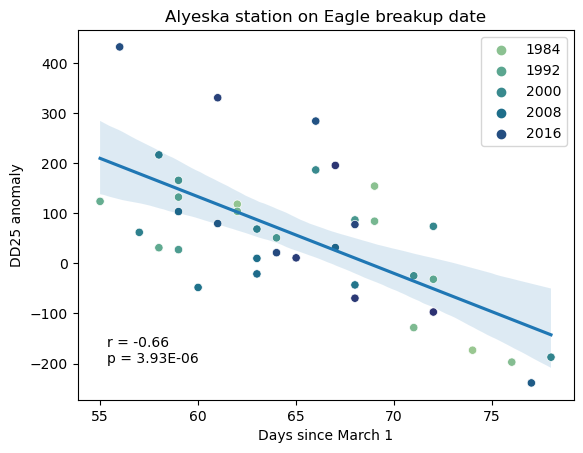

ANCHORAGE_MERRILL_FIELD


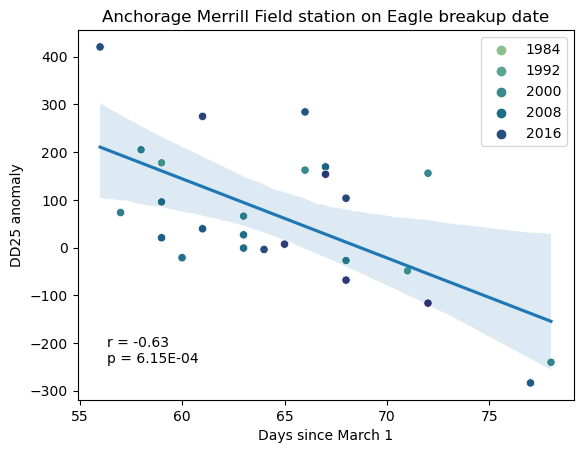

ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT


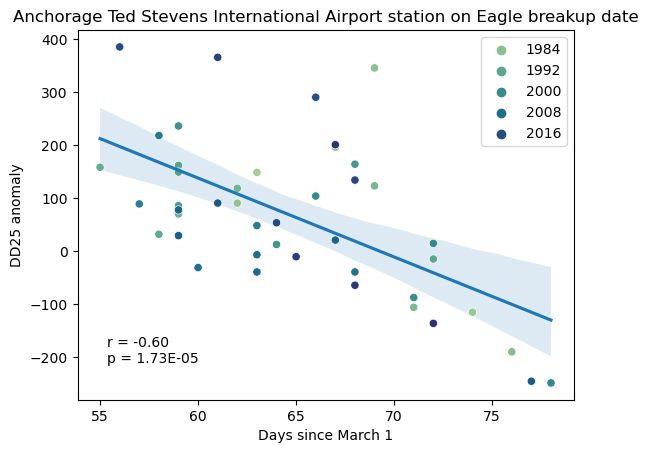

AUKE_BAY


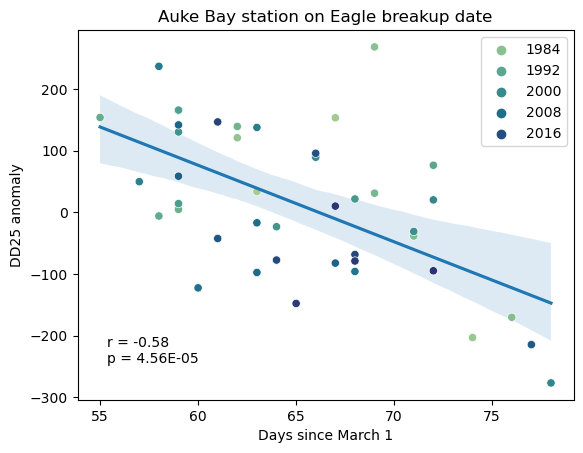

BARROW_AIRPORT


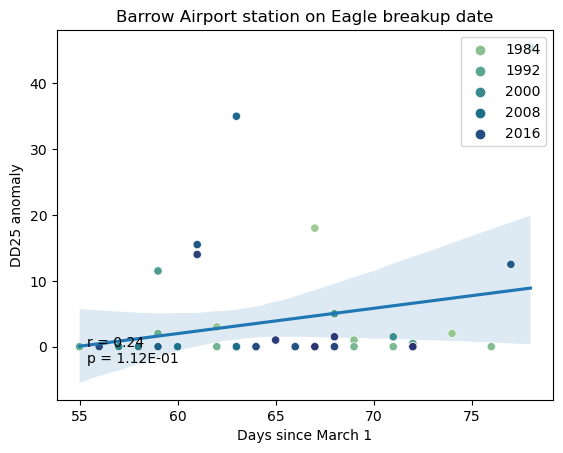

BETHEL_AIRPORT


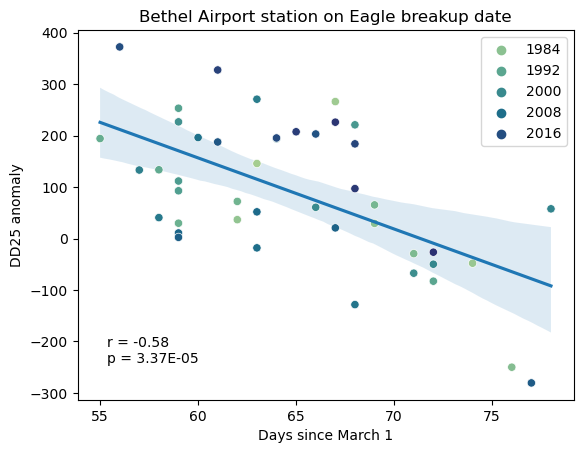

BETTLES_AIRPORT


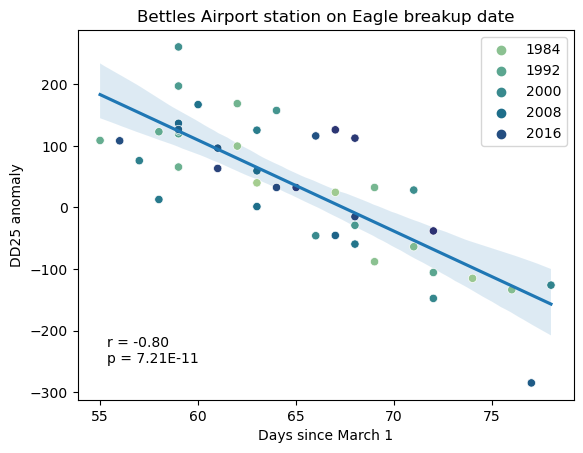

BIG_DELTA_AIRPORT


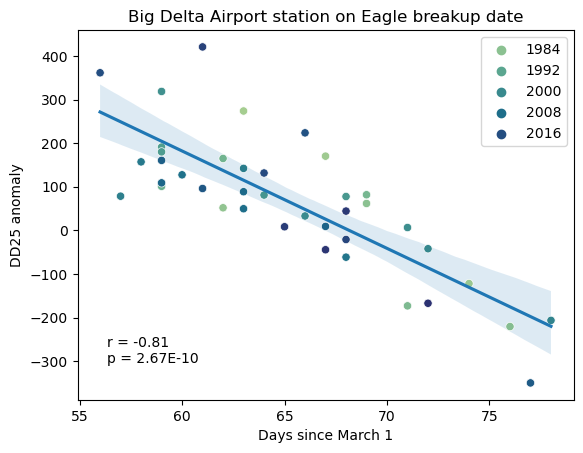

CHICKEN


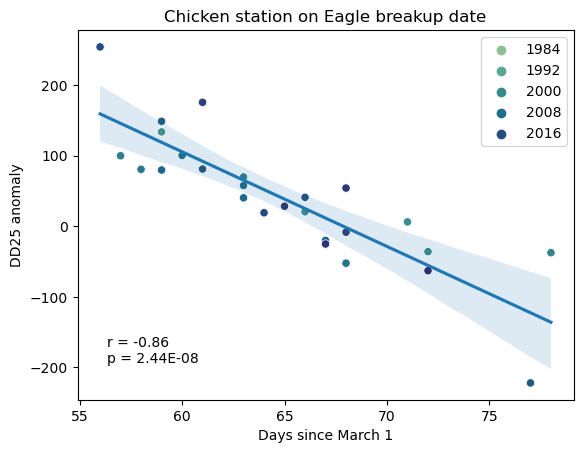

COLD_BAY_AIRPORT


COLLEGE_OBSERVATORY


CORDOVA_AIRPORT


DUTCH_HARBOR


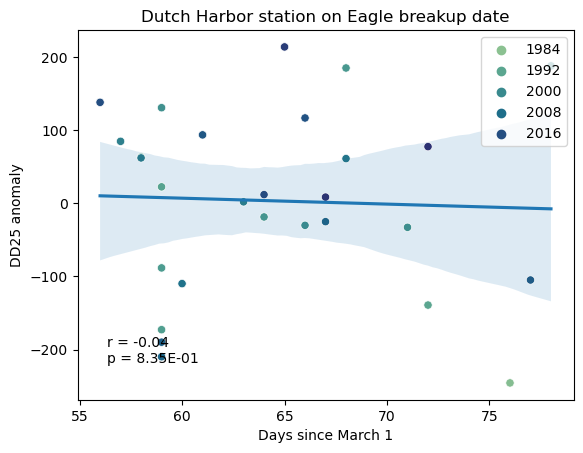

EAGLE


FAIRBANKS_INTL_AP


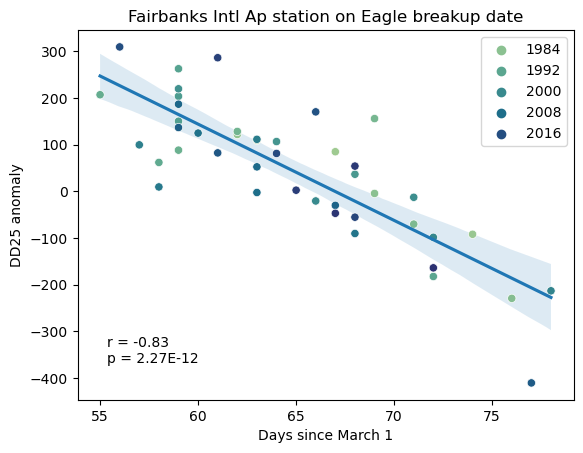

GULKANA_AIRPORT


HAINES_AIRPORT


HOMER_AIRPORT


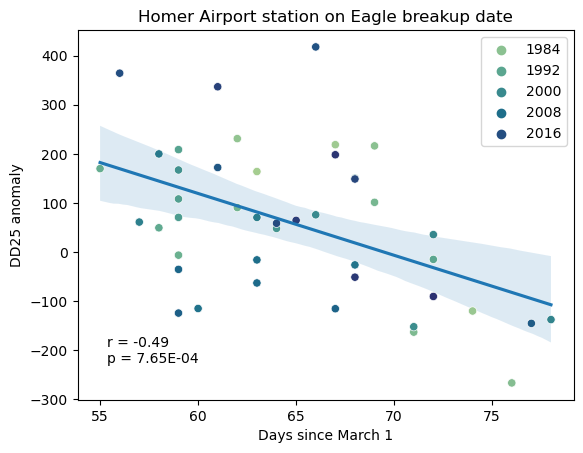

ILIAMNA_AIRPORT


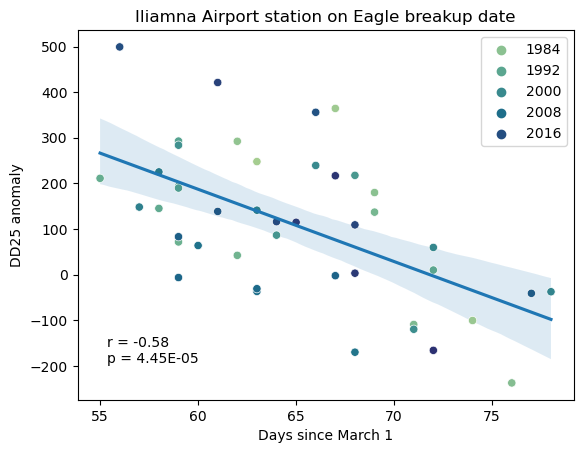

JUNEAU_AIRPORT


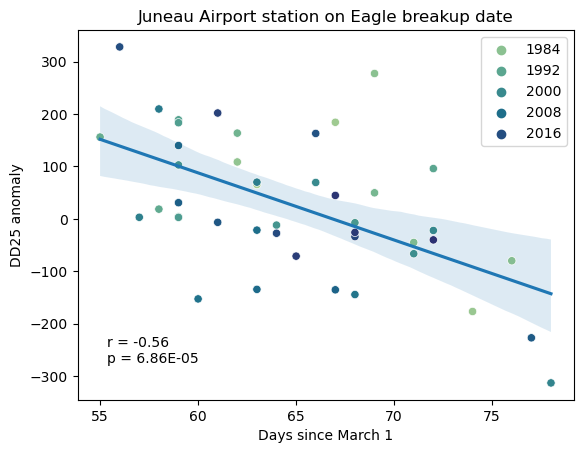

KENAI_AIRPORT


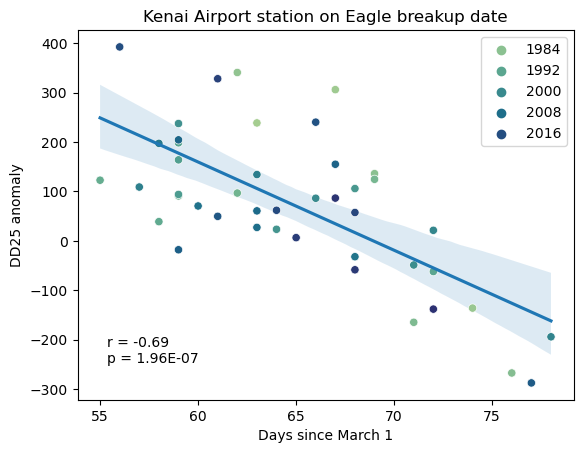

KETCHIKAN_AIRPORT


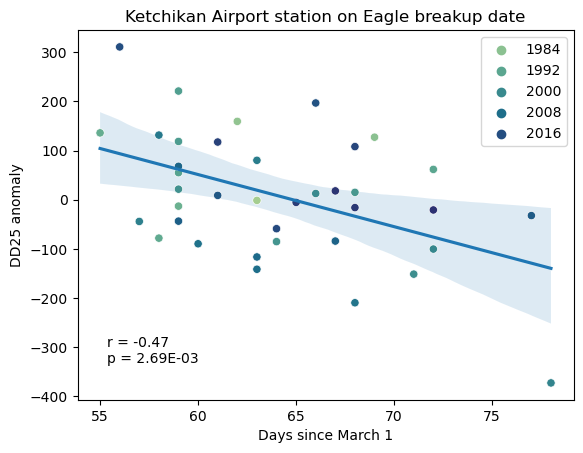

KING_SALMON_AIRPORT


KODIAK_AIRPORT


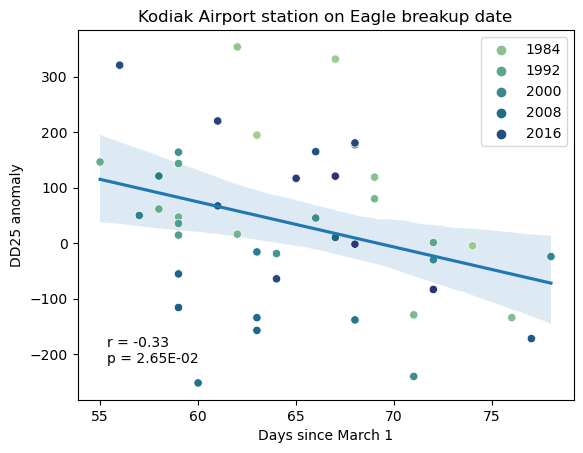

KOTZEBUE_AIRPORT


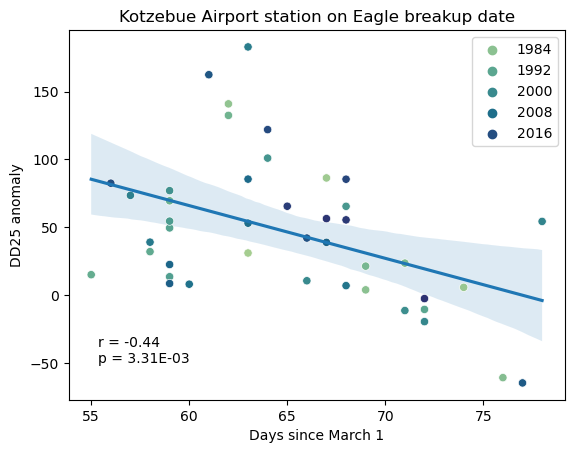

MCGRATH_AP


MCKINLEY_PARK


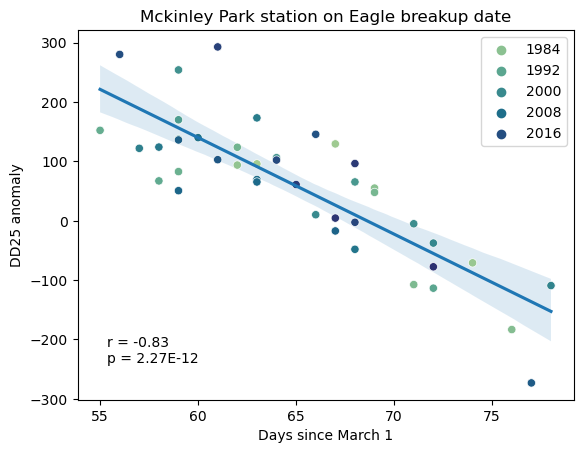

NENANA_MUN_AP


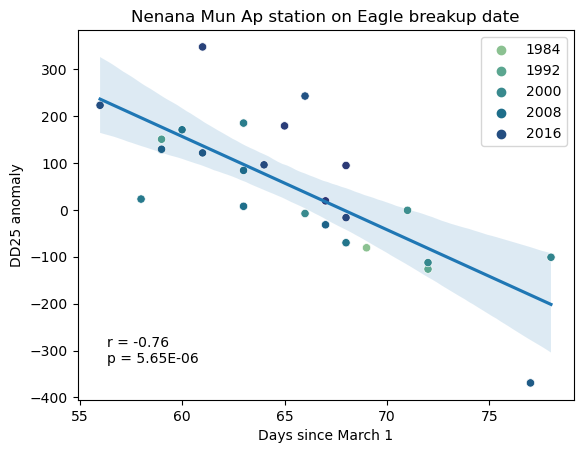

NOME_AIRPORT


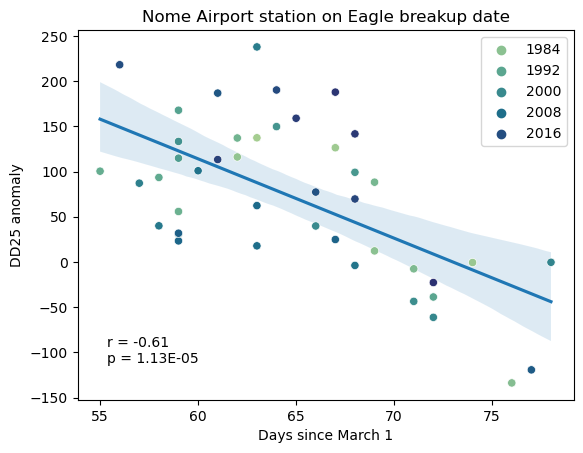

NORTHWAY_AIRPORT


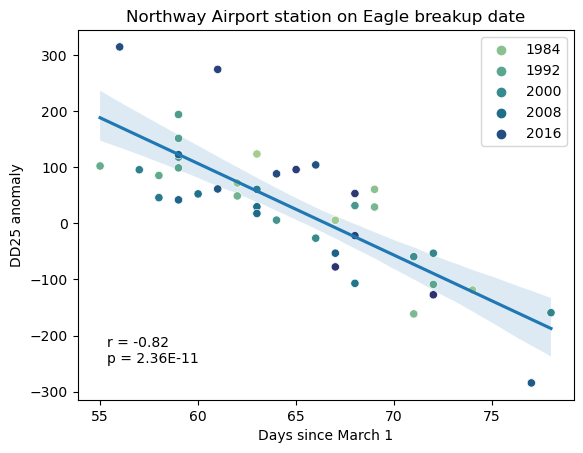

NORTH_POLE


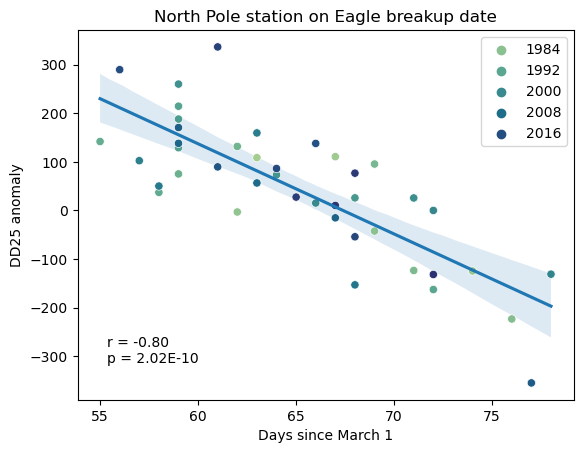

SAINT_PAUL_ISLAND_AIRPORT


SITKA_AIRPORT


SKAGWAY_AIRPORT


TALKEETNA_AIRPORT


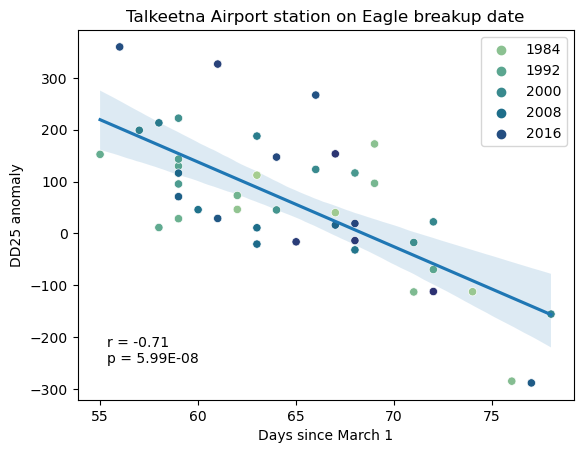

TANANA_AIRPORT


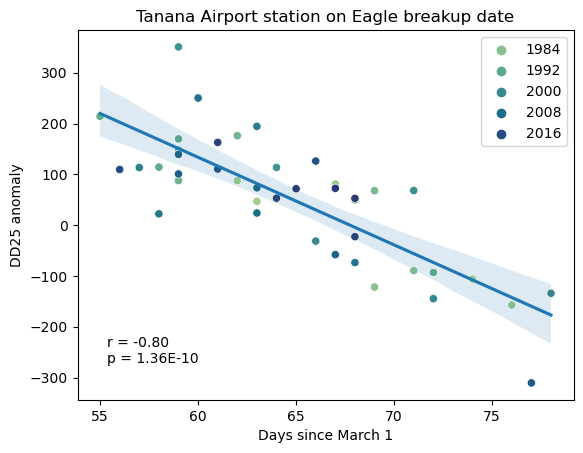

YAKUTAT_AIRPORT


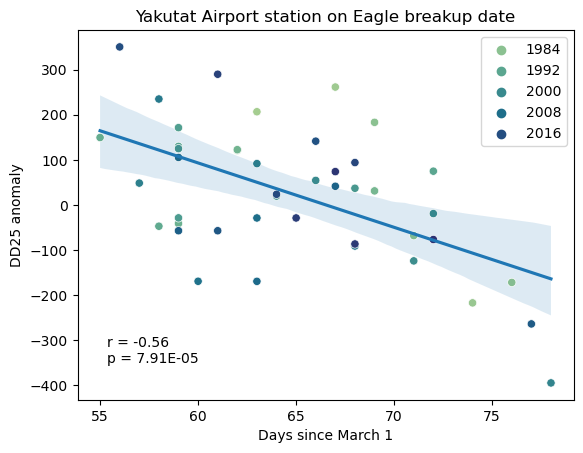

In [ ]:
for stationname in breakup_anomaly.columns[6:]:
    print(stationname)
    sb.regplot(data=breakup_anomaly, x='days_since_march1', y=stationname, scatter=False)
    ax = sb.scatterplot(data=breakup_anomaly, x='days_since_march1', y=stationname, hue='year', palette="crest")
    ax.set_title(f"{stationname.replace('_', ' ').title()} station on Eagle breakup date")
    ax.set_ylabel(f"{prefix} anomaly")
    ax.set_xlabel("Days since March 1")
    plt.legend(loc='upper right')
    result = breakup_anomaly[stationname].corr(breakup_anomaly['days_since_march1'],
                method=lambda x, y: pearsonr(x, y))
    ax.text(0.06, 0.1, f'r = {result.statistic:.2f}\np = {result.pvalue:.2E}', transform=ax.transAxes)
    plt.show()

In [ ]:
breakup_anomaly

id                siteID  year     breakup  JulianDay  \
0   5330  Yukon River at Eagle  1980  1980-05-03        124   
1   5331  Yukon River at Eagle  1981  1981-05-07        127   
2   5332  Yukon River at Eagle  1982  1982-05-14        134   
3   5333  Yukon River at Eagle  1983  1983-05-02        122   
4   5334  Yukon River at Eagle  1984  1984-05-09        130   
5   5335  Yukon River at Eagle  1985  1985-05-16        136   
6   5336  Yukon River at Eagle  1986  1986-05-11        131   
7   5337  Yukon River at Eagle  1987  1987-05-09        129   
8   5338  Yukon River at Eagle  1988  1988-05-02        123   
9   5339  Yukon River at Eagle  1989  1989-04-29        119   
10  5340  Yukon River at Eagle  1990  1990-04-25        115   
11  5341  Yukon River at Eagle  1991  1991-04-28        118   
12  5342  Yukon River at Eagle  1992  1992-05-12        133   
13  5343  Yukon River at Eagle  1993  1993-04-29        119   
14  5344  Yukon River at Eagle  1994  1994-04-29        119   
15  5345  Yukon River at Eagle  1995  1995-04-29        119   
16  5346  Yukon River at Eagle  1996  1996-05-08        129   
17  5347  Yukon River at Eagle  1997  1997-05-04        124   
18  5348  Yukon River at Eagle  1998  1998-04-29        119   
19  5349  Yukon River at Eagle  1999  1999-05-11        131   
20  5350  Yukon River at Eagle  2000  2000-05-06        127   
21  5351  Yukon River at Eagle  2001  2001-05-12        132   
22  5352  Yukon River at Eagle  2002  2002-05-18        138   
23  6208  Yukon River at Eagle  2003  2003-04-27        117   
24  6215  Yukon River at Eagle  2004  2004-05-03        124   
25  6262  Yukon River at Eagle  2005  2005-04-28        118   
26  6291  Yukon River at Eagle  2006  2006-05-08        128   
27  6334  Yukon River at Eagle  2007  2007-04-30        120   
28  6385  Yukon River at Eagle  2008  2008-05-03        124   
29  6403  Yukon River at Eagle  2009  2009-05-03        123   
30  6429  Yukon River at Eagle  2010  2010-04-29        119   
31  6465  Yukon River at Eagle  2011  2011-05-07        127   
32  6489  Yukon River at Eagle  2012  2012-04-29        120   
33  6543  Yukon River at Eagle  2013  2013-05-17        137   
34  6591  Yukon River at Eagle  2014  2014-05-01        121   
35  6672  Yukon River at Eagle  2015  2015-05-06        126   
36  6729  Yukon River at Eagle  2016  2016-04-26        117   
37  6797  Yukon River at Eagle  2017  2017-05-04        124   
38  6888  Yukon River at Eagle  2018  2018-05-08        128   
39  6942  Yukon River at Eagle  2019  2019-05-01        121   
40  7001  Yukon River at Eagle  2020  2020-05-05        126   
41  7067  Yukon River at Eagle  2021  2021-05-08        128   
42  7135  Yukon River at Eagle  2022  2022-05-07        127   
43  7195  Yukon River at Eagle  2023  2023-05-12        132   

    days_since_march1  ALYESKA  ANCHORAGE_MERRILL_FIELD  \
0                  63      NaN                      NaN   
1                  67      NaN                      NaN   
2                  74  -173.35                      NaN   
3                  62   117.99                      NaN   
4                  69   154.11                      NaN   
5                  76  -197.12                      NaN   
6                  71  -128.28                      NaN   
7                  69    84.02                      NaN   
8                  62   103.78                      NaN   
9                  59      NaN                      NaN   
10                 55   123.63                      NaN   
11                 58    31.17                      NaN   
12                 72   -31.79                      NaN   
13                 59   164.81                      NaN   
14                 59   132.13                      NaN   
15                 59    27.31                      NaN   
16                 68    86.62                      NaN   
17                 64    50.84                      NaN   
18                 59   165.61                   

In [ ]:
# breakup_only = breakup_anomaly[breakup_anomaly.columns[4:]]
breakup_only = breakup[breakup.columns[4:]]
breakup_standardized = ((breakup_only - breakup_only.mean())/breakup_only.std())
breakup_standardized

JulianDay  days_since_march1
0   -0.188777          -0.315202
1    0.319765           0.361330
2    1.506364           1.545261
3   -0.527805          -0.484336
4    0.828307           0.699596
5    1.845392           1.883527
6    0.997821           1.037862
7    0.658793           0.699596
8   -0.358291          -0.484336
9   -1.036347          -0.991735
10  -1.714404          -1.668267
11  -1.205861          -1.160868
12   1.336850           1.206995
13  -1.036347          -0.991735
14  -1.036347          -0.991735
15  -1.036347          -0.991735
16   0.658793           0.530463
17  -0.188777          -0.146069
18  -1.036347          -0.991735
19   0.997821           1.037862
20   0.319765           0.192197
21   1.167336           1.206995
22   2.184420           2.221793
23  -1.375376          -1.330001
24  -0.188777          -0.315202
25  -1.205861          -1.160868
26   0.489279           0.530463
27  -0.866833          -0.822602
28  -0.188777          -0.315202
29  -0.358291          -0.315202
30  -1.036347          -0.991735
31   0.319765           0.361330
32  -0.866833          -0.991735
33   2.014906           2.052660
34  -0.697319          -0.653469
35   0.150251           0.192197
36  -1.375376          -1.499134
37  -0.188777          -0.146069
38   0.489279           0.530463
39  -0.697319          -0.653469
40   0.150251           0.023064
41   0.489279           0.530463
42   0.319765           0.361330
43   1.167336           1.206995

In [ ]:
breakup_only.std().to_frame().T

JulianDay  days_since_march1
0   5.899215           5.912505

In [ ]:
breakup_standardized[breakup_standardized.columns[1:]].corrwith(breakup_standardized['days_since_march1'],
                method=lambda x, y: pearsonr(x, y)[1])

days_since_march1    0.0
dtype: float64

In [ ]:
breakup

id                siteID  year     breakup  JulianDay  days_since_march1
0   5330  Yukon River at Eagle  1980  1980-05-03        124                 63
1   5331  Yukon River at Eagle  1981  1981-05-07        127                 67
2   5332  Yukon River at Eagle  1982  1982-05-14        134                 74
3   5333  Yukon River at Eagle  1983  1983-05-02        122                 62
4   5334  Yukon River at Eagle  1984  1984-05-09        130                 69
5   5335  Yukon River at Eagle  1985  1985-05-16        136                 76
6   5336  Yukon River at Eagle  1986  1986-05-11        131                 71
7   5337  Yukon River at Eagle  1987  1987-05-09        129                 69
8   5338  Yukon River at Eagle  1988  1988-05-02        123                 62
9   5339  Yukon River at Eagle  1989  1989-04-29        119                 59
10  5340  Yukon River at Eagle  1990  1990-04-25        115                 55
11  5341  Yukon River at Eagle  1991  1991-04-28        118                 58
12  5342  Yukon River at Eagle  1992  1992-05-12        133                 72
13  5343  Yukon River at Eagle  1993  1993-04-29        119                 59
14  5344  Yukon River at Eagle  1994  1994-04-29        119                 59
15  5345  Yukon River at Eagle  1995  1995-04-29        119                 59
16  5346  Yukon River at Eagle  1996  1996-05-08        129                 68
17  5347  Yukon River at Eagle  1997  1997-05-04        124                 64
18  5348  Yukon River at Eagle  1998  1998-04-29        119                 59
19  5349  Yukon River at Eagle  1999  1999-05-11        131                 71
20  5350  Yukon River at Eagle  2000  2000-05-06        127                 66
21  5351  Yukon River at Eagle  2001  2001-05-12        132                 72
22  5352  Yukon River at Eagle  2002  2002-05-18        138                 78
23  6208  Yukon River at Eagle  2003  2003-04-27        117                 57
24  6215  Yukon River at Eagle  2004  2004-05-03        124                 63
25  6262  Yukon River at Eagle  2005  2005-04-28        118                 58
26  6291  Yukon River at Eagle  2006  2006-05-08        128                 68
27  6334  Yukon River at Eagle  2007  2007-04-30        120                 60
28  6385  Yukon River at Eagle  2008  2008-05-03        124                 63
29  6403  Yukon River at Eagle  2009  2009-05-03        123                 63
30  6429  Yukon River at Eagle  2010  2010-04-29        119                 59
31  6465  Yukon River at Eagle  2011  2011-05-07        127                 67
32  6489  Yukon River at Eagle  2012  2012-04-29        120                 59
33  6543  Yukon River at Eagle  2013  2013-05-17        137                 77
34  6591  Yukon River at Eagle  2014  2014-05-01        121                 61
35  6672  Yukon River at Eagle  2015  2015-05-06        126                 66
36  6729  Yukon River at Eagle  2016  2016-04-26        117                 56
37  6797  Yukon River at Eagle  2017  2017-05-04        124                 64
38  6888  Yukon River at Eagle  2018  2018-05-08        128                 68
39  6942  Yukon River at Eagle  2019  2019-05-01        121                 61
40  7001  Yukon River at Eagle  2020  2020-05-05        126                 65
41  7067  Yukon River at Eagle  2021  2021-05-08        128                 68
42  7135  Yukon River at Eagle  2022  2022-05-07        127                 67
43  7195  Yukon River at Eagle  2023  2023-05-12        132                 72

In [ ]:
breakup_standardized[breakup_standardized.columns[1:]].corrwith(breakup_standardized['days_since_march1'],
            method=lambda x, y: pearsonr(x, y)[1])

days_since_march1    0.0
dtype: float64

In [ ]:
breakup

id                siteID  year     breakup  JulianDay  days_since_march1
0   5330  Yukon River at Eagle  1980  1980-05-03        124                 63
1   5331  Yukon River at Eagle  1981  1981-05-07        127                 67
2   5332  Yukon River at Eagle  1982  1982-05-14        134                 74
3   5333  Yukon River at Eagle  1983  1983-05-02        122                 62
4   5334  Yukon River at Eagle  1984  1984-05-09        130                 69
5   5335  Yukon River at Eagle  1985  1985-05-16        136                 76
6   5336  Yukon River at Eagle  1986  1986-05-11        131                 71
7   5337  Yukon River at Eagle  1987  1987-05-09        129                 69
8   5338  Yukon River at Eagle  1988  1988-05-02        123                 62
9   5339  Yukon River at Eagle  1989  1989-04-29        119                 59
10  5340  Yukon River at Eagle  1990  1990-04-25        115                 55
11  5341  Yukon River at Eagle  1991  1991-04-28        118                 58
12  5342  Yukon River at Eagle  1992  1992-05-12        133                 72
13  5343  Yukon River at Eagle  1993  1993-04-29        119                 59
14  5344  Yukon River at Eagle  1994  1994-04-29        119                 59
15  5345  Yukon River at Eagle  1995  1995-04-29        119                 59
16  5346  Yukon River at Eagle  1996  1996-05-08        129                 68
17  5347  Yukon River at Eagle  1997  1997-05-04        124                 64
18  5348  Yukon River at Eagle  1998  1998-04-29        119                 59
19  5349  Yukon River at Eagle  1999  1999-05-11        131                 71
20  5350  Yukon River at Eagle  2000  2000-05-06        127                 66
21  5351  Yukon River at Eagle  2001  2001-05-12        132                 72
22  5352  Yukon River at Eagle  2002  2002-05-18        138                 78
23  6208  Yukon River at Eagle  2003  2003-04-27        117                 57
24  6215  Yukon River at Eagle  2004  2004-05-03        124                 63
25  6262  Yukon River at Eagle  2005  2005-04-28        118                 58
26  6291  Yukon River at Eagle  2006  2006-05-08        128                 68
27  6334  Yukon River at Eagle  2007  2007-04-30        120                 60
28  6385  Yukon River at Eagle  2008  2008-05-03        124                 63
29  6403  Yukon River at Eagle  2009  2009-05-03        123                 63
30  6429  Yukon River at Eagle  2010  2010-04-29        119                 59
31  6465  Yukon River at Eagle  2011  2011-05-07        127                 67
32  6489  Yukon River at Eagle  2012  2012-04-29        120                 59
33  6543  Yukon River at Eagle  2013  2013-05-17        137                 77
34  6591  Yukon River at Eagle  2014  2014-05-01        121                 61
35  6672  Yukon River at Eagle  2015  2015-05-06        126                 66
36  6729  Yukon River at Eagle  2016  2016-04-26        117                 56
37  6797  Yukon River at Eagle  2017  2017-05-04        124                 64
38  6888  Yukon River at Eagle  2018  2018-05-08        128                 68
39  6942  Yukon River at Eagle  2019  2019-05-01        121                 61
40  7001  Yukon River at Eagle  2020  2020-05-05        126                 65
41  7067  Yukon River at Eagle  2021  2021-05-08        128                 68
42  7135  Yukon River at Eagle  2022  2022-05-07        127                 67
43  7195  Yukon River at Eagle  2023  2023-05-12        132                 72

In [ ]:
mean_EAGLE = breakup['EAGLE'].mean()
mean_EAGLE

KeyError: 'EAGLE'

In [ ]:
teststationDF

1980    1981    1982    1983    1984    1985    1986  \
d_since_march1                                                           
0                  8.0    14.0     0.0     6.5    13.5     2.5     4.0   
1                 16.0    27.5     0.0    10.0    25.0    11.5     6.0   
2                 26.0    35.5     0.0    11.5    35.5    17.5    11.0   
3                 32.0    39.5     0.0    14.5    49.0    17.5    18.5   
4                 44.0    52.0     7.5    16.5    62.0    17.5    20.0   
...                ...     ...     ...     ...     ...     ...     ...   
117             2130.0  2332.0  1573.0  2071.0  1993.5  1544.0  1736.5   
118             2161.0  2361.0  1598.5  2103.5  2017.0  1568.0  1759.5   
119             2191.5  2390.0  1626.0  2136.0  2038.0  1593.0  1788.0   
120             2217.5  2417.5  1654.5  2167.5  2062.5  1627.5  1814.0   
121             2241.0  2447.0  1681.0  2196.5  2087.0  1662.0  1848.5   

                  1987    1988    1989  ...    2014    2015    2016    2017  \
d_since_march1                          ...                                   
0                  0.0    14.0     0.0  ...     2.0    11.0    10.5     2.5   
1                  0.0    23.5     0.0  ...     3.0    21.5    19.5     2.5   
2                  0.0    29.5     3.0  ...     3.0    33.5    28.0     2.5   
3                  0.0    36.0     6.0  ...     3.5    47.0    38.5     2.5   
4                  0.0    47.5     7.0  ...     3.5    61.0    51.5     2.5   
...                ...     ...     ...  ...     ...     ...     ...     ...   
117             1834.5  1979.0  1839.5  ...  1847.0  2175.0  2440.0  1951.0   
118             1860.5  2003.0  1871.0  ...  1875.5  2204.5  2469.5  1979.0   
119             1886.5  2024.0  1900.0  ...  1908.5  2236.0  2500.0  2007.5   
120             1917.0  2049.0  1927.0  ...  1941.5  2264.5  2529.0  2037.0   
121             1942.5  2074.0  1955.0  ...  1972.0  2294.5  2558.0  2066.0   

                  2018     2019    2020    2021    2022    2023  
d_since_march1                                                   
0                  0.0     7.00    11.5     8.5     9.0     4.5  
1                  0.0    13.50    21.0    18.0    17.0    10.5  
2                  0.0    23.50    26.0    26.0    25.5    10.5  
3                  4.5    29.50    31.5    32.0    34.5    10.5  
4                  4.5    32.00    34.5    35.5    46.5    10.5  
...                ...      ...     ...     ...     ...     ...  
117             2032.5  2350.23  1938.5  1769.5  2030.5  1840.5  
118             2058.0  2378.45  1966.0  1802.5  2061.5  1871.5  
119             2088.0  2417.45  1990.0  1835.0  2092.5  1903.0  
120             2117.5  2455.95  2018.5  1862.0  2122.0  1930.5  
121             2145.5  2490.45  2047.5  1891.0  2152.5  1957.0  

[122 rows x 44 columns]

In [ ]:
breakup.apply(lambda row: climatologies.loc[row.days_since_march1], axis=1)

GULKANA_AIRPORT  TANANA_AIRPORT  KETCHIKAN_AIRPORT  COLLEGE_OBSERVATORY  \
0            273.70          185.55            1005.42               300.62   
1            338.16          245.98            1091.61               369.49   
2            468.75          383.02            1257.12               525.58   
3            257.91          172.48             984.27               283.43   
4            373.53          282.07            1137.36               410.18   
5            508.25          427.26            1307.33               572.52   
6            410.32          321.90            1184.83               455.87   
7            373.53          282.07            1137.36               410.18   
8            257.91          172.48             984.27               283.43   
9            213.81          131.72             920.08               232.74   
10           156.94           80.76             836.48               168.56   
11           199.40          117.75             899.63               216.43   
12           430.20          342.64            1208.88               479.62   
13           213.81          131.72             920.08               232.74   
14           213.81          131.72             920.08               232.74   
15           213.81          131.72             920.08               232.74   
16           355.82          263.14            1114.56               388.87   
17           288.94          198.43            1026.97               316.62   
18           213.81          131.72             920.08               232.74   
19           410.32          321.90            1184.83               455.87   
20           320.73          228.86            1069.88               350.19   
21           430.20          342.64            1208.88               479.62   
22           549.80          472.07            1358.03               618.98   
23           185.40          105.15             879.21               200.45   
24           273.70          185.55            1005.42               300.62   
25           199.40          117.75             899.63               216.43   
26           355.82          263.14            1114.56               388.87   
27           228.36          146.24             940.60               250.20   
28           273.70          185.55            1005.42               300.62   
29           273.70          185.55            1005.42               300.62   
30           213.81          131.72             920.08               232.74   
31           338.16          245.98            1091.61               369.49   
32           213.81          131.72             920.08               232.74   
33           528.61          449.50            1332.31               595.48   
34           243.24          159.62             962.25               266.80   
35           320.73          228.86            1069.88               350.19   
36           170.78           92.48             857.88               183.60   
37           288.94          198.43            1026.97               316.62   
38           355.82          263.14            1114.56               388.87   
39           243.24          159.62             962.25               266.80   
40           304.51          212.81            1048.50               333.27   
41           355.82          263.14            1114.56               388.87   
42           338.16          245.98            1091.61               369.49   
43           430.20          342.64            1208.88               479.62   

    AUKE_BAY  BETHEL_AIRPORT  ANCHORAGE_MERRILL_FIELD  SKAGWAY_AIRPORT  \
0     836.55          171.65                   521.08           821.18   
1     921.87          221.80                   604.88           907.24   
2    1090.07          333.03                   767.06          1078.37   
3     814.95          161.35                   501.04           799.51   
4     967.08          249.10                   648.78           954.71   
5   

In [ ]:
sb.scatterplot(data=breakup, x='days_since_march1', y='EAGLE', hue='year')

ValueError: Could not interpret value `EAGLE` for parameter `y`

<AxesSubplot: xlabel='days_since_march1', ylabel='AUKE_BAY'>

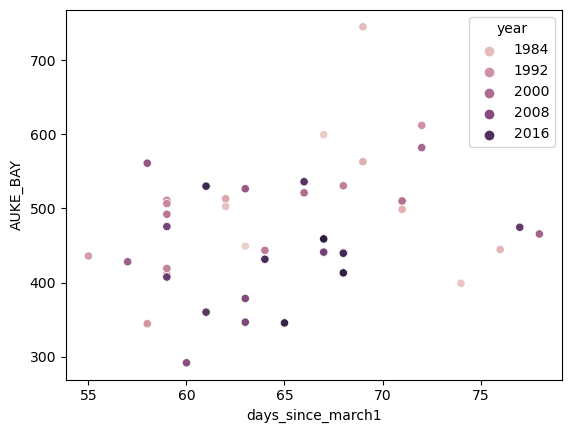

In [ ]:
sb.scatterplot(data=breakup, x='days_since_march1', y='AUKE_BAY', hue='year')

## Model breakup by DD anomaly for all locations

Load breakup data again and recalculate anomaly dataframe.

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup_anomaly = breakup.copy()

for pth in dd:
    stationname = pth.stem[:-14-len(prefix)]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
locations = breakup.siteID.unique()
locations

array(['Chena River at Fairbanks', 'Kuskokwim River at Nikolai',
       'Gakona River at Gakona', 'Gulkana River nr Gakona',
       'Tanana River at Nenana', 'Yukon River at Dawson',
       'Yentna River at Lake Creek', 'Susitna River at Sunshine',
       'Yukon River at Eagle', 'Kuskokwim River at Stony River',
       'Kuskokwim River at Sleetmute',
       'Tanana River nr Manley Hot Springs', 'Kuskokwim River at McGrath',
       'Kuskokwim River at Red Devil', 'Kuskokwim River at Crooked Creek',
       'Koyukuk River at Allakaket', 'Yukon River at Tanana',
       'Yukon River at Fort Yukon', 'Yukon River at Circle',
       'Koyukuk River at Bettles', 'Koyukuk River at Hughes',
       'Kuskokwim River at Aniak', 'Yukon River at Ruby',
       'Kuskokwim River at Kalskag', 'Kuskokwim River at Tuluksak',
       'Kuskokwim River at Akiak', 'Yukon River at Galena',
       'Kuskokwim River at Bethel', 'Yukon River at Kaltag',
       'Yukon River at Holy Cross', 'Yukon River at Anvik',
     

In [ ]:
breakup_anomaly

id                      siteID  year     breakup  JulianDay  \
0     7185    Chena River at Fairbanks  2023  2023-04-30        120   
1     7186  Kuskokwim River at Nikolai  2023  2023-05-02        122   
2     7188      Gakona River at Gakona  2023  2023-05-05        125   
3     7189     Gulkana River nr Gakona  2023  2023-05-02        122   
4     7190      Tanana River at Nenana  2023  2023-05-08        128   
...    ...                         ...   ...         ...        ...   
1529  5998         Yukon River at Ruby  1980  1980-05-07        128   
1530  6165       Yukon River at Tanana  1980  1980-05-03        124   
1531  6276       Yukon River at Dawson  1980  1980-05-06        127   
1532  6521       Yukon River at Galena  1980  1980-05-10        131   
1533  6856    Chena River at Fairbanks  1959  2017-05-01        121   

      days_since_march1  ALYESKA  ANCHORAGE_MERRILL_FIELD  \
0                    60   -66.62                   -88.22   
1                    62   -66.72                   -90.54   
2                    65   -77.56                  -106.36   
3                    62   -66.72                   -90.54   
4                    68   -85.09                  -117.06   
...                 ...      ...                      ...   
1529                 67      NaN                      NaN   
1530                 63      NaN                      NaN   
1531                 66      NaN                      NaN   
1532                 70      NaN                      NaN   
1533                 61      NaN                      NaN   

      ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT  AUKE_BAY  ...  \
0                                         -104.19    -99.20  ...   
1                                         -107.04    -97.95  ...   
2                                         -123.17   -109.25  ...   
3                                         -107.04    -97.95  ...   
4                                         -129.99   -106.44  ...   
...                                           ...       ...  ...   
1529                                       149.23     48.64  ...   
1530                                       148.53     33.46  ...   
1531                                       149.36     43.09  ...   
1532                                       150.81     58.86  ...   
1533                                          NaN       NaN  ...   

      NENANA_MUN_AP  NOME_AIRPORT  NORTHWAY_AIRPORT  NORTH_POLE  \
0               NaN          8.89            -99.10     -137.54   
1               NaN         17.11            -99.73     -127.78   
2               NaN         10.93           -114.76     -126.58   
3               NaN         17.11            -99.73     -127.78   
4               NaN         -0.84           -121.41     -129.32   
...             ...           ...               ...         ...   
1529            NaN        185.83            144.34      132.30   
1530            NaN        137.33            123.55      108.62   
1531            NaN        175.80            138.07      126.48   
1532            NaN        218.19            149.83      128.57   
1533            NaN           NaN               NaN         NaN   

      SAINT_PAUL_ISLAND_AIRPORT  SITKA_AIRPORT  SKAGWAY_AIRPORT  \
0                        156.85         -25.44           -48.47   
1                        153.09         -25.36           -47.01   
2                        147.66         -30.88           -57.91   
3                        153.09         -25.36           -47.01   
4                        145.72         -29.23           -55.16   
...                         ...            ...              ...   
1529                     262.96          90.40              NaN   
1530                     246.11          71.97              NaN   
1531                     258.44          87.12              NaN   
1532                     271.47          99.22              NaN   
1533                        NaN            NaN              NaN

In [ ]:
def calculate_corr(breakupDF=breakup_anomaly, show_plots=False, save_plots=False, 
               prefix=f"{prefix}_breakupday", locations=locations, stationnames=None):
    if not set(locations) <= set(breakupDF.siteID):
        raise Exception("Sorry, the location isn't available in the breakup dataset. Check spelling?")
    outputrecords = []
    for location in locations:
        testDF = breakupDF[breakupDF.siteID == location].sort_values(
            by='year').reset_index(drop=True)
        if stationnames is None:
            stationnames = testDF.columns[5:]
        if not set(stationnames) <= set(breakupDF.columns):
            raise Exception(f"Sorry, the {stationnames} isn't in valid names: {breakupDF.columns}")
        for stationname in stationnames:
            result = testDF[stationname].corr(testDF['days_since_march1'],
                        method=lambda x, y: pearsonr(x, y))
            outputrecords.append(
                {
                    "stationname": stationname,  
                    "location": location,
                    "pvalue": result.pvalue,
                    "rvalue": result.statistic,
                    "r2value": result.statistic**2
                }
            )        
            if show_plots or save_plots:
                sb.regplot(data=testDF, y='days_since_march1', x=stationname, scatter=False)
                ax = sb.scatterplot(data=testDF, y='days_since_march1', x=stationname, 
                                    hue='year', palette="crest")
                ax.set_title(f"{stationname.replace('_', ' ').title()} station for {location} "
                             f"{prefix.replace('_', ' ')}")
                ax.set_xlabel(f"{prefix} anomaly")
                ax.set_ylabel("Days since March 1")
                plt.legend(loc='upper right')
                ax.text(0.06, 0.1, 
                        f'r = {result.statistic:.2f}\nr2 = {result.statistic**2:.2f}\np = {result.pvalue:.2E}', 
                        transform=ax.transAxes)
                if save_plots:
                    fn = f"{prefix}_{location.replace(' ', '_')}_AT_{stationname}.png"
                    plt.savefig(outpath / fn, bbox_inches='tight')
                    plt.close()
                if show_plots:
                    plt.show()
    return outputrecords
    

Make plots for all on breakup date

In [ ]:
calculate_corr(save_plots=False)

[{'stationname': 'days_since_march1',
  'location': 'Chena River at Fairbanks',
  'pvalue': 0.0,
  'rvalue': 1.0,
  'r2value': 1.0},
 {'stationname': 'ALYESKA',
  'location': 'Chena River at Fairbanks',
  'pvalue': 0.0033096154787992933,
  'rvalue': -0.5270145913867033,
  'r2value': 0.2777443795344938},
 {'stationname': 'ANCHORAGE_MERRILL_FIELD',
  'location': 'Chena River at Fairbanks',
  'pvalue': 0.003750559220866602,
  'rvalue': -0.6170794909103764,
  'r2value': 0.3807870981022093},
 {'stationname': 'ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT',
  'location': 'Chena River at Fairbanks',
  'pvalue': 0.003601479977711957,
  'rvalue': -0.5070389259599873,
  'r2value': 0.2570884724386575},
 {'stationname': 'AUKE_BAY',
  'location': 'Chena River at Fairbanks',
  'pvalue': 0.010074746671068132,
  'rvalue': -0.462483036623902,
  'r2value': 0.2138905591648655},
 {'stationname': 'BARROW_AIRPORT',
  'location': 'Chena River at Fairbanks',
  'pvalue': 0.11154325219292373,
  'rvalue': 0.291537

In [ ]:
outpath

PosixPath('/Users/chris/Projects/2023_Riverice/data/breakupdata/working')

In [ ]:
returnrec = calculate_corr(locations=['Yukon River at Eagle'], 
                           stationnames=['CHICKEN'], save_plots=True)

In [ ]:
returnrec = calculate_corr()

In [ ]:
resultsDF_p = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2 = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
resultsDF_r2

stationname                          ALYESKA  ANCHORAGE_MERRILL_FIELD  \
location                                                                
Buckland River at Buckland          0.245065                 0.077223   
Chena River at Fairbanks            0.277744                 0.380787   
Chisana River at Northway           0.677113                 0.680813   
Gakona River at Gakona              0.209354                 0.131929   
Gulkana River nr Gakona             0.170141                 0.127446   
Kobuk River at Ambler               0.209282                 0.113295   
Kobuk River at Kobuk                0.224077                 0.147191   
Kobuk River at Shungnak             0.264221                 0.188753   
Koyukuk River at Allakaket          0.239328                 0.151780   
Koyukuk River at Bettles            0.173469                 0.147525   
Koyukuk River at Hughes             0.268624                 0.158032   
Kuskokwim River at Akiak            0.514780                 0.416635   
Kuskokwim River at Aniak            0.495069                 0.350268   
Kuskokwim River at Bethel           0.528162                 0.445939   
Kuskokwim River at Crooked Creek    0.446208                 0.410017   
Kuskokwim River at Kalskag          0.518219                 0.452407   
Kuskokwim River at McGrath          0.445807                 0.376334   
Kuskokwim River at Nikolai          0.492649                 0.588082   
Kuskokwim River at Red Devil        0.410383                 0.320024   
Kuskokwim River at Sleetmute        0.397918                 0.438413   
Kuskokwim River at Stony River      0.405141                 0.376643   
Kuskokwim River at Tuluksak         0.462555                 0.459553   
Susitna River at Sunshine           0.586614                 0.563478   
Tanana River at Nenana              0.511955                 0.444513   
Tanana River nr Manley Hot Springs  0.448482                 0.432820   
Yentna River at Lake Creek          0.586410                 0.564477   
Yukon River at Alakanuk             0.427222                 0.245581   
Yukon River at Anvik                0.370426                 0.237529   
Yukon River at Circle               0.249421                 0.197100   
Yukon River at Dawson               0.622703                 0.512615   
Yukon River at Eagle                0.433098                 0.392587   
Yukon River at Fort Yukon           0.250933                 0.241300   
Yukon River at Galena               0.432816                 0.364367   
Yukon River at Holy Cross           0.452978                 0.278563   
Yukon River at Kaltag               0.381633                 0.217513   
Yukon River at Marshall             0.540380                 0.561517   
Yukon River at Mountain Village     0.448640                 0.261338   
Yukon River at Ruby                 0.372276                 0.253704   
Yukon River at Russian Mission      0.431171                 0.315279   
Yukon River at Tanana               0.415159                 0.314686   
Yukon River nr Emmonak              0.436114                 0.280681   

stationname                         ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT  \
location                                                                          
Buckland River at Buckland                                             0.172825   
Chena River at Fairbanks                                               0.257088   
Chisana River at Northway                                              0.508104   
Gakona River at Gakona                                                 0.203401   
Gulkana River nr Gakona                                                0.136195   
Kobuk River at Ambler                                                  0.223557   
Kobuk River at Kobuk                                                   0.193174   
Kobuk River at Shungnak                                                0.205596   
Koyukuk River at Allakaket    

In [ ]:
with open(outpath / f"breakupday_{prefix}_corr_pvalues.csv", "w") as dst:
    dst.write(f"# Correlations between Degree Days > {config[prefix]['deltaT']} (F) anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p.to_csv(dst)
with open(outpath / f"breakupday_{prefix}_corr_r2values.csv", "w") as dst:
    dst.write(f"# Correlation R2 between Degree Days > {config[prefix]['deltaT']} (F) anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between DD25 anomaly on breakup date, and breakup date')

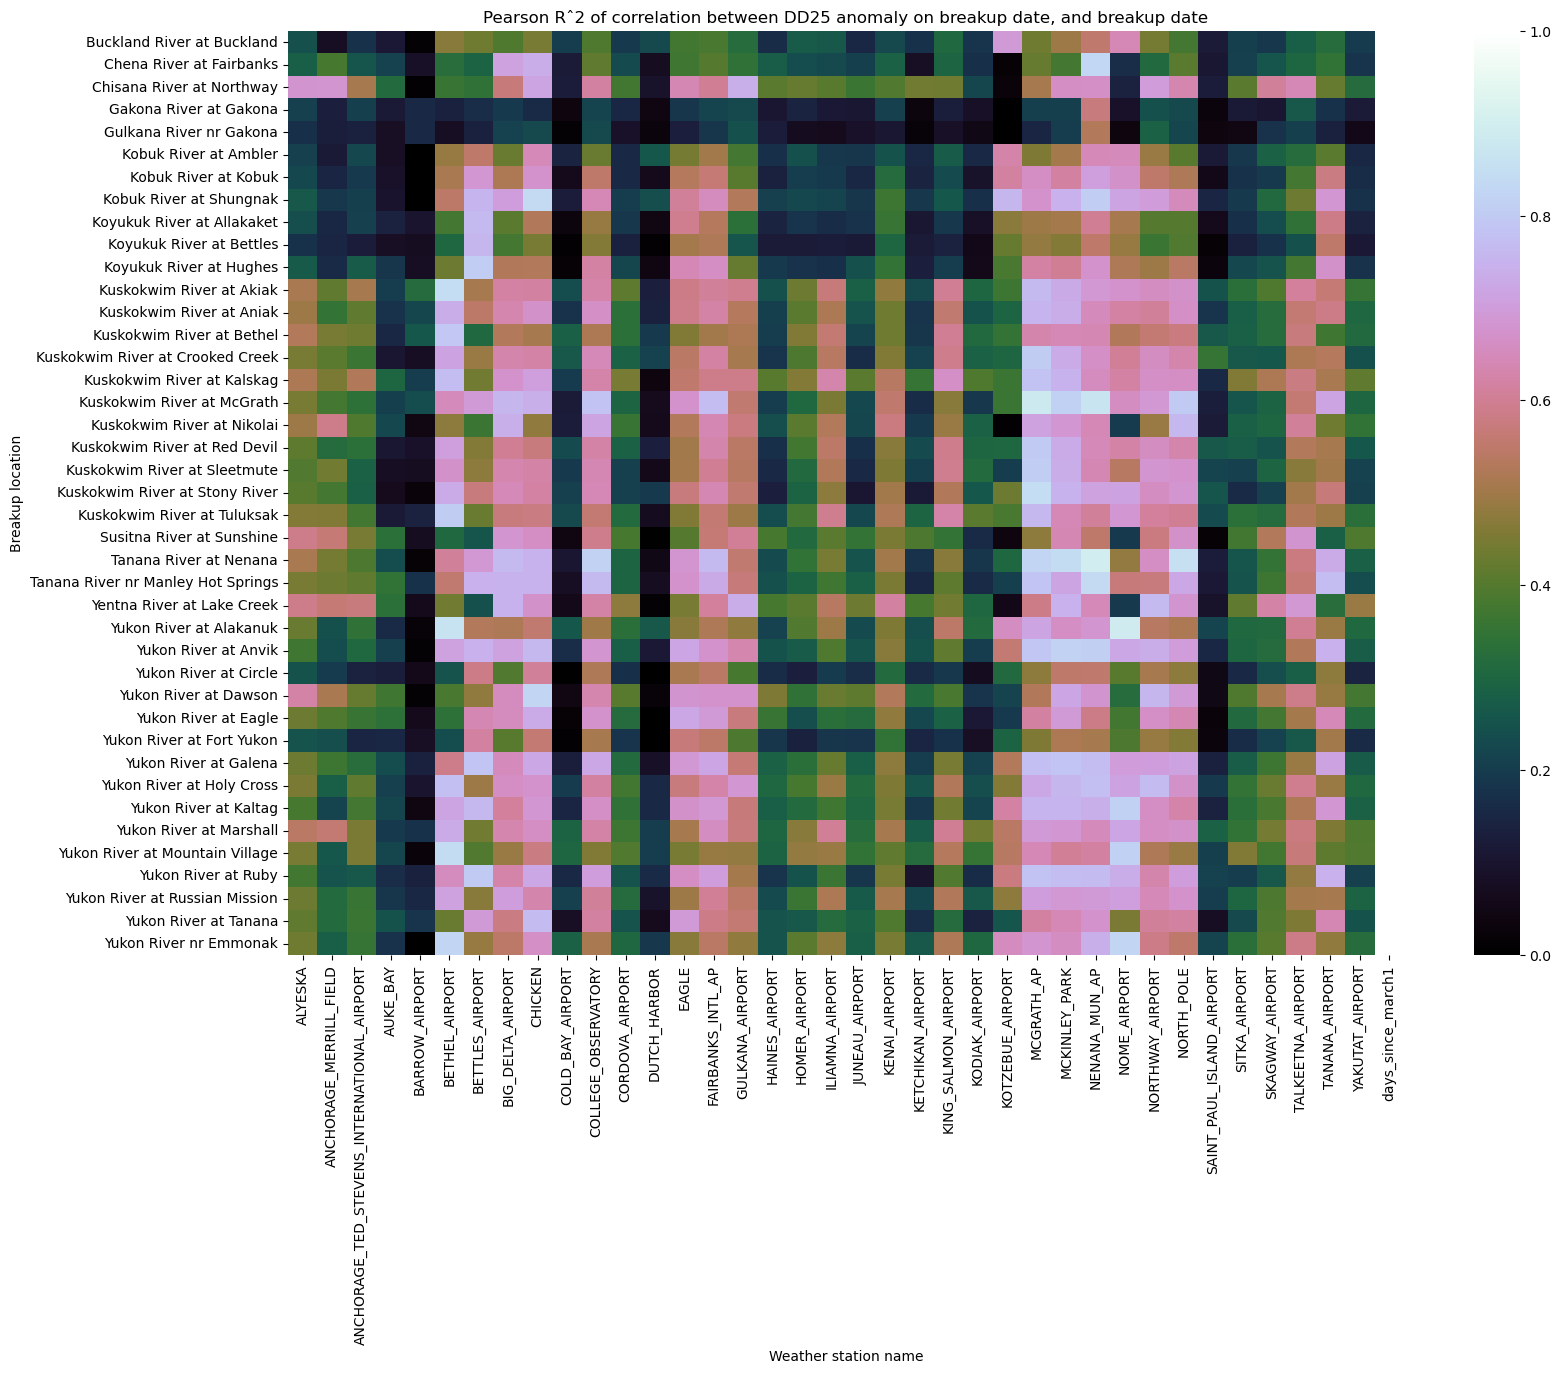

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title(f"Pearson Rˆ2 of correlation between {prefix} anomaly on breakup date, and breakup date")

Text(0.5, 1.0, 'Log10 of p-value of correlation between TDD anomaly and breakup date')

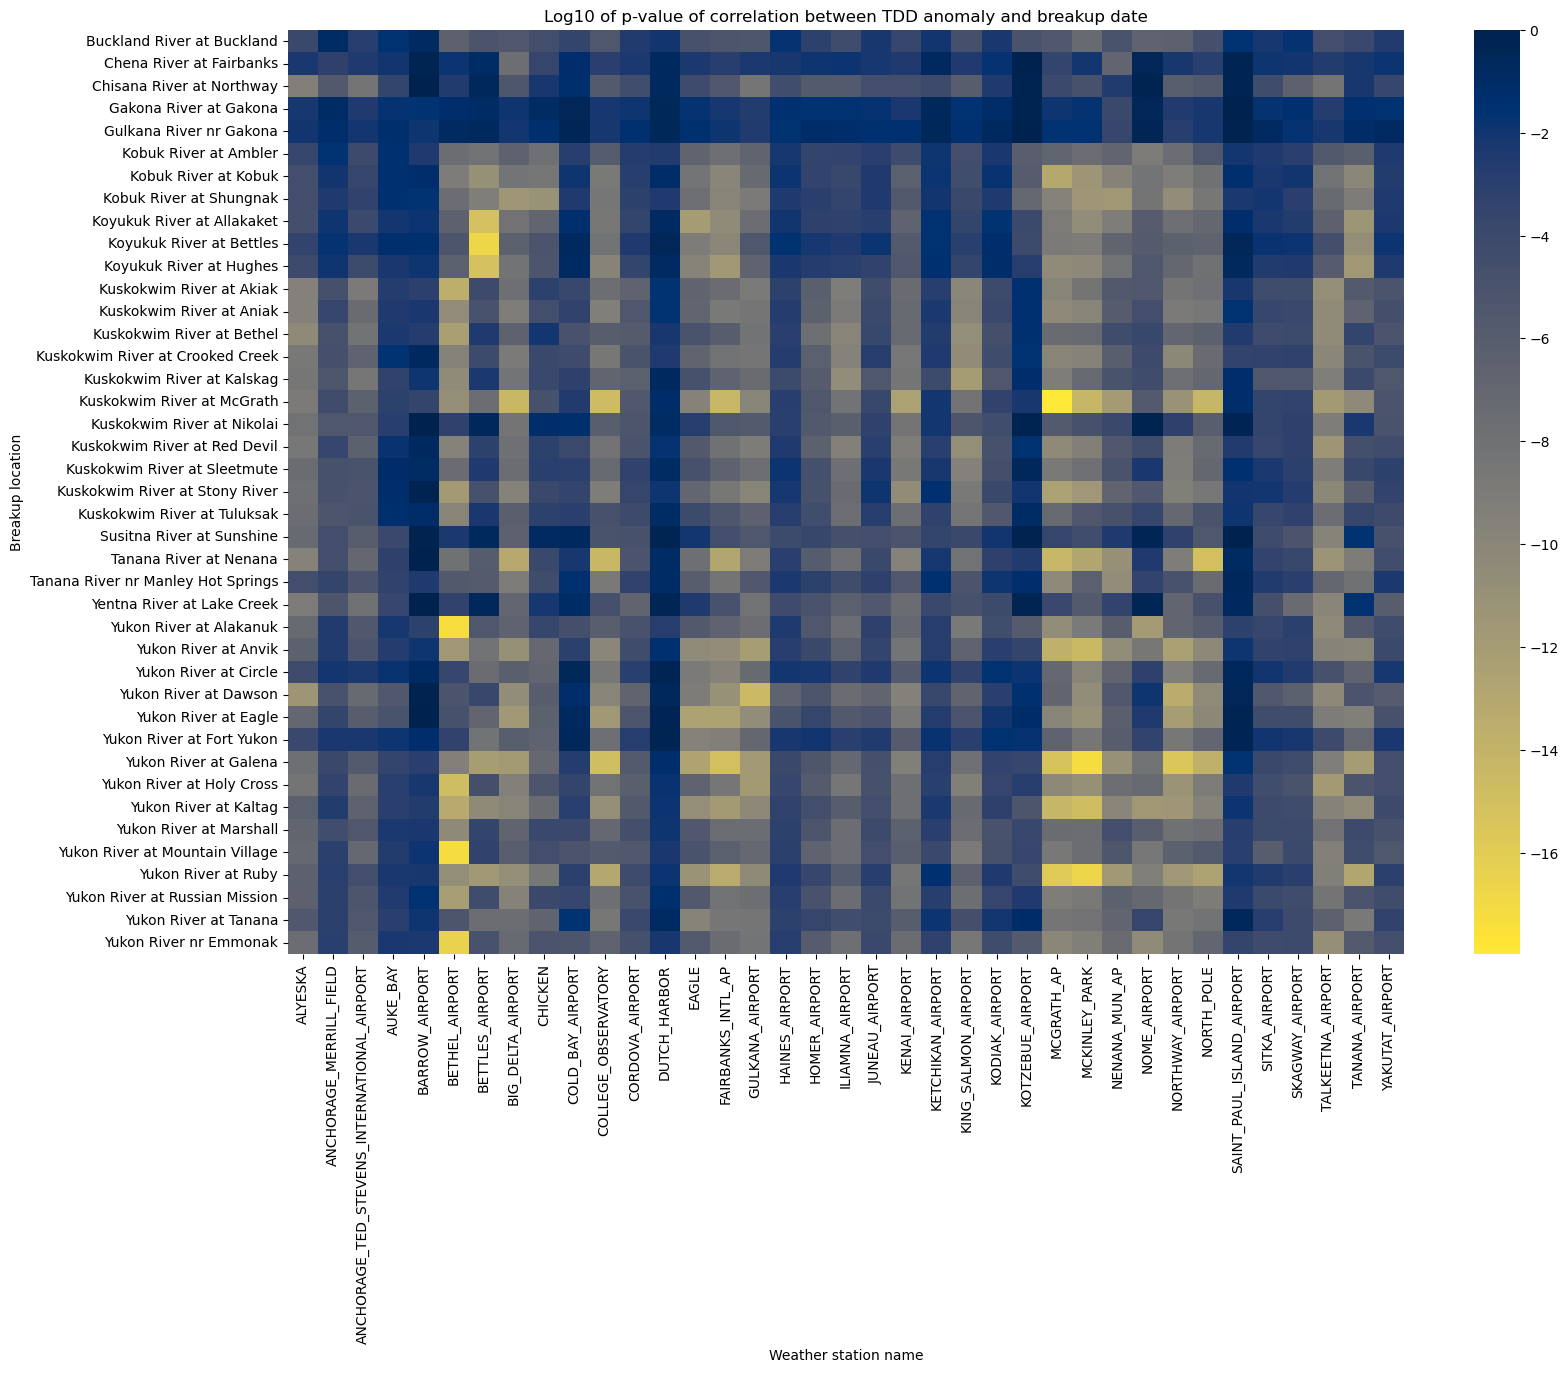

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    np.log10(resultsDF_p), 
    cmap='cividis_r', xticklabels=True, yticklabels=True)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Log10 of p-value of correlation between TDD anomaly and breakup date")

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops 

Top1  \
location                                                        
Buckland River at Buckland                     BARROW_AIRPORT   
Chena River at Fairbanks                     KOTZEBUE_AIRPORT   
Chisana River at Northway                      BARROW_AIRPORT   
Gakona River at Gakona              SAINT_PAUL_ISLAND_AIRPORT   
Gulkana River nr Gakona                      KOTZEBUE_AIRPORT   
Kobuk River at Ambler                                AUKE_BAY   
Kobuk River at Kobuk                           BARROW_AIRPORT   
Kobuk River at Shungnak                              AUKE_BAY   
Koyukuk River at Allakaket                       DUTCH_HARBOR   
Koyukuk River at Bettles            SAINT_PAUL_ISLAND_AIRPORT   
Koyukuk River at Hughes             SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at Akiak                     KOTZEBUE_AIRPORT   
Kuskokwim River at Aniak                     KOTZEBUE_AIRPORT   
Kuskokwim River at Bethel                    KOTZEBUE_AIRPORT   
Kuskokwim River at Crooked Creek               BARROW_AIRPORT   
Kuskokwim River at Kalskag                       DUTCH_HARBOR   
Kuskokwim River at McGrath          SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at Nikolai                     BARROW_AIRPORT   
Kuskokwim River at Red Devil                   BARROW_AIRPORT   
Kuskokwim River at Sleetmute                 KOTZEBUE_AIRPORT   
Kuskokwim River at Stony River                 BARROW_AIRPORT   
Kuskokwim River at Tuluksak                  KOTZEBUE_AIRPORT   
Susitna River at Sunshine           SAINT_PAUL_ISLAND_AIRPORT   
Tanana River at Nenana                         BARROW_AIRPORT   
Tanana River nr Manley Hot Springs  SAINT_PAUL_ISLAND_AIRPORT   
Yentna River at Lake Creek                     BARROW_AIRPORT   
Yukon River at Alakanuk                              AUKE_BAY   
Yukon River at Anvik                           BARROW_AIRPORT   
Yukon River at Circle                            DUTCH_HARBOR   
Yukon River at Dawson                          BARROW_AIRPORT   
Yukon River at Eagle                           BARROW_AIRPORT   
Yukon River at Fort Yukon                        DUTCH_HARBOR   
Yukon River at Galena               SAINT_PAUL_ISLAND_AIRPORT   
Yukon River at Holy Cross                      BARROW_AIRPORT   
Yukon River at Kaltag               SAINT_PAUL_ISLAND_AIRPORT   
Yukon River at Marshall                        BARROW_AIRPORT   
Yukon River at Mountain Village                BARROW_AIRPORT   
Yukon River at Ruby                         KETCHIKAN_AIRPORT   
Yukon River at Russian Mission                 BARROW_AIRPORT   
Yukon River at Tanana               SAINT_PAUL_ISLAND_AIRPORT   
Yukon River nr Emmonak                               AUKE_BAY   

                                                         Top2  \
location                                                        
Buckland River at Buckland            ANCHORAGE_MERRILL_FIELD   
Chena River at Fairbanks                       BARROW_AIRPORT   
Chisana River at Northway                        NOME_AIRPORT   
Gakona River at Gakona                       KOTZEBUE_AIRPORT   
Gulkana River nr Gakona             SAINT_PAUL_ISLAND_AIRPORT   
Kobuk River at Ambler                       KETCHIKAN_AIRPORT   
Kobuk River at Kobuk                SAINT_PAUL_ISLAND_AIRPORT   
Kobuk River at Shungnak                        BARROW_AIRPORT   
Koyukuk River at Allakaket          SAINT_PAUL_ISLAND_AIRPORT   
Koyukuk River at Bettles                         DUTCH_HARBOR   
Koyukuk River at Hughes                      COLD_BAY_AIRPORT   
Kuskokwim River at Akiak                         DUTCH_HARBOR   
Kuskokwim River at Aniak            SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at Bethel                     BETTLES_AIRPORT   
Kuskokwim River at Crooked Creek             KOTZEBUE_AIRPORT   
Kuskokwim River at Kalskag          SAINT_PAUL_ISLAND_AIRPORT   
Kuskokwim River at McGrath                       DUTCH_HARBOR   
Kuskokwim River at Nikolai

Now for 15 days before breakupm

In [ ]:
breakup_anomaly_offset = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_offset[stationname] = breakup_anomaly_offset.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF, offset=10), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_offset)

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
resultsDF_p_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / "breakupdayminus15_TDD_corr_pvalues.csv", "w") as dst:
    dst.write("# Correlations between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_offset.to_csv(dst)
with open(outpath / "breakupdayminus15_TDD_corr_r2values.csv", "w") as dst:
    dst.write("# Correlation R2 between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_offset.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date')

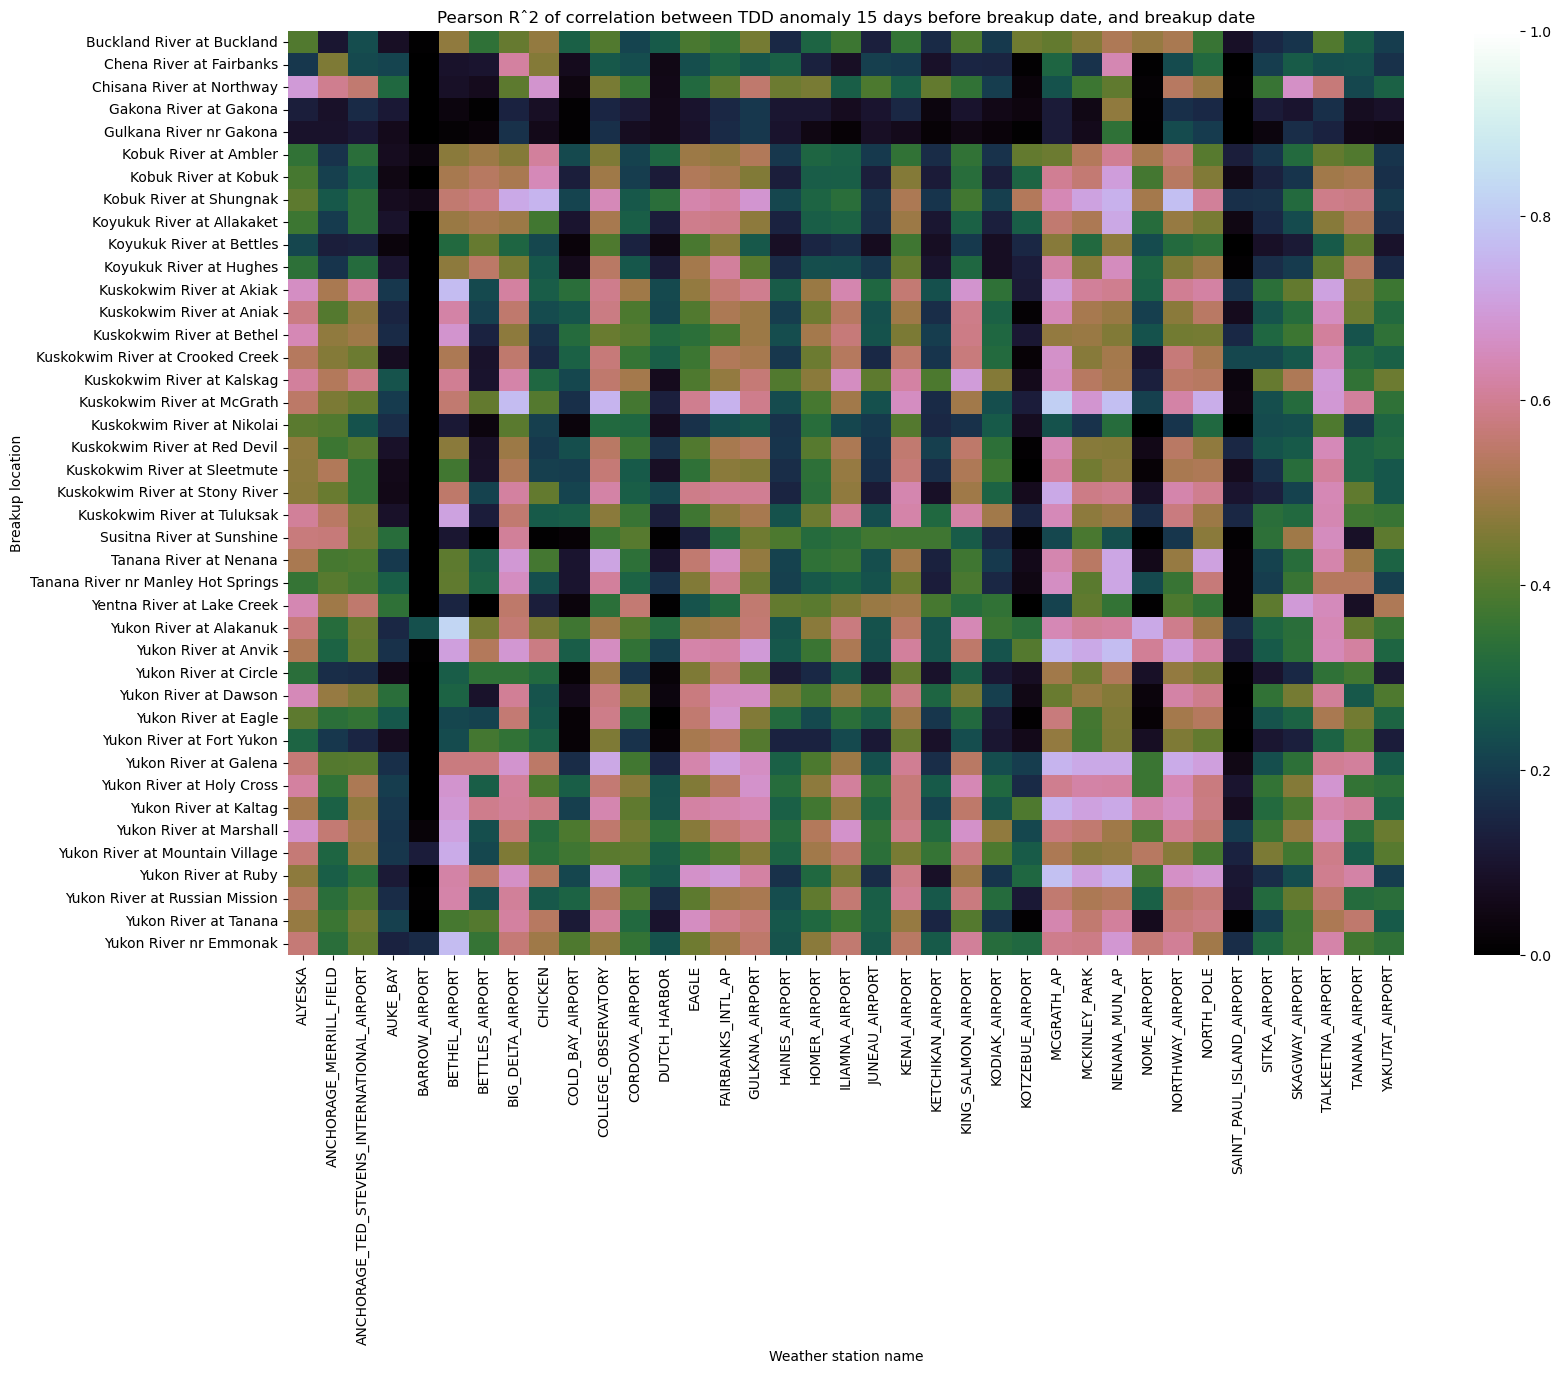

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_offset, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date")

Now for April 15th, or May 1, or whatever.

In [ ]:
datestr = "04-15"
textstr = "April 15"
fnstr = textstr.replace(" ", "")

In [ ]:
breakup_anomaly_fixed = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
        lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    # breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
    #     lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, "04-15"), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed)

In [ ]:
resultsDF_p_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / f"{fnstr}_TDD_corr_pvalues.csv", "w") as dst:
    dst.write(f"# Correlations between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_fixed.to_csv(dst)
with open(outpath / f"{fnstr}_TDD_corr_r2values.csv", "w") as dst:
    dst.write(f"# Correlation R2 between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_fixed.to_csv(dst)   
    

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly on April 15, and breakup date')

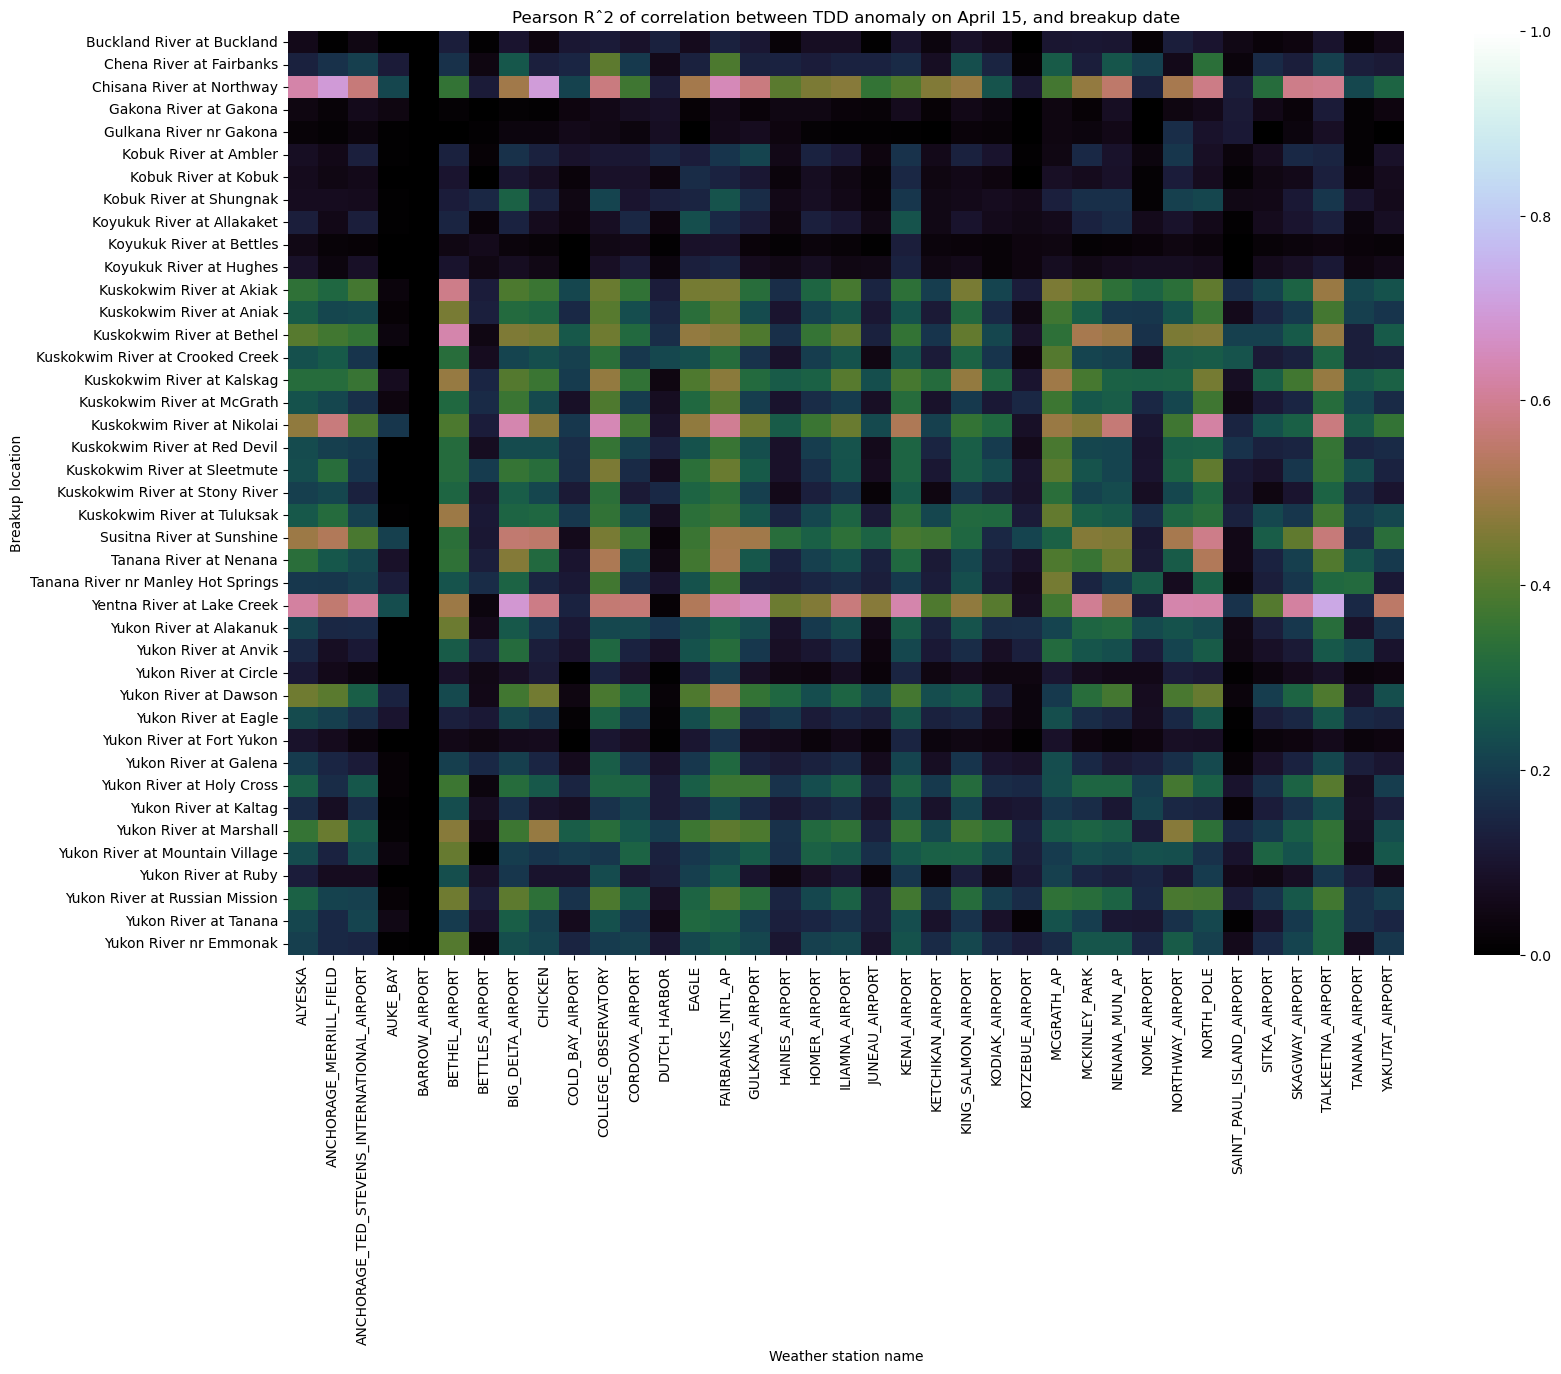

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_fixed, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title(f"Pearson Rˆ2 of correlation between TDD anomaly on {textstr}, and breakup date")

### Write top correlations to files

In [ ]:
results_r2_dict = resultsDF_r2.T.to_dict()
topstations_breakupday = {}
for location in results_r2_dict:
    topstations_breakupday[location] = dict(sorted(results_r2_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupday.json", "w") as dst:
    json.dump(topstations_breakupday, dst, indent=2)

In [ ]:
results_r2_offset_dict = resultsDF_r2_offset.T.to_dict()
topstations_breakupdayminus15 = {}
for location in results_r2_dict:
    topstations_breakupdayminus15[location] = dict(sorted(results_r2_offset_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupdayminus15.json", "w") as dst:
    json.dump(topstations_breakupdayminus15, dst, indent=2)

In [ ]:
results_r2_April25_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April25 = {}
for location in results_r2_April25_dict:
    topstations_April25[location] = dict(sorted(results_r2_April25_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April25.json", "w") as dst:
    json.dump(topstations_April25, dst, indent=2)

In [ ]:
results_r2_April15_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April15 = {}
for location in results_r2_April15_dict:
    topstations_April15[location] = dict(sorted(results_r2_April15_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April15.json", "w") as dst:
    json.dump(topstations_April15, dst, indent=2)

In [ ]:
import itertools

In [ ]:
maxN = 5
resultsdicts = {"breakupday": topstations_breakupday, 
                "breakupdayminus15": topstations_breakupdayminus15, 
                "April25": topstations_April25, 
                "April15": topstations_April15}

roundrobin = itertools.cycle(resultsdicts)

selectedstations = {}
locations = resultsdicts["breakupday"].keys()
for location in locations:
    print(f"Working on {location}")
    selectedstations[location] = set()
    ii = 0
    jj = 0
    for label in roundrobin:
        dict = resultsdicts[label]
        print(f"For {label}...")
        try:
            print(f"Retrieving element {ii}: {sorted(dict[location].items(), key=lambda x: -x[1])[ii][0]}")
            selectedstations[location].add(sorted(dict[location].items(), key=lambda x: -x[1])[ii][0])
        except IndexError:
            continue
        jj += 1
        ii = jj // 4 
        if len(selectedstations[location]) == maxN:
            selectedstations[location] = list(selectedstations[location])
            break


Working on Buckland River at Buckland
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 0: KOTZEBUE_AIRPORT
For April15...
Retrieving element 0: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: MCKINLEY_PARK
For breakupdayminus15...
Retrieving element 1: NORTHWAY_AIRPORT
Working on Chena River at Fairbanks
For April25...
Retrieving element 0: NENANA_MUN_AP
For April15...
Retrieving element 0: COLLEGE_OBSERVATORY
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 1: COLLEGE_OBSERVATORY
For April15...
Retrieving element 1: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: BIG_DELTA_AIRPORT
For breakupdayminus15...
Retrieving element 1: BIG_DELTA_AIRPORT
For April25...
Retrieving element 2: BIG_DELTA_AIRPORT
For April15...
Retrieving element 2: NORTH_POLE
Working on Chisana Rive

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops.to_json()

'{"Top1":{"Buckland River at Buckland":"BARROW_AIRPORT","Chena River at Fairbanks":"KOTZEBUE_AIRPORT","Chisana River at Northway":"BARROW_AIRPORT","Gakona River at Gakona":"SAINT_PAUL_ISLAND_AIRPORT","Gulkana River nr Gakona":"KOTZEBUE_AIRPORT","Kobuk River at Ambler":"AUKE_BAY","Kobuk River at Kobuk":"BARROW_AIRPORT","Kobuk River at Shungnak":"AUKE_BAY","Koyukuk River at Allakaket":"DUTCH_HARBOR","Koyukuk River at Bettles":"SAINT_PAUL_ISLAND_AIRPORT","Koyukuk River at Hughes":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Akiak":"KOTZEBUE_AIRPORT","Kuskokwim River at Aniak":"KOTZEBUE_AIRPORT","Kuskokwim River at Bethel":"KOTZEBUE_AIRPORT","Kuskokwim River at Crooked Creek":"BARROW_AIRPORT","Kuskokwim River at Kalskag":"DUTCH_HARBOR","Kuskokwim River at McGrath":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Nikolai":"BARROW_AIRPORT","Kuskokwim River at Red Devil":"BARROW_AIRPORT","Kuskokwim River at Sleetmute":"KOTZEBUE_AIRPORT","Kuskokwim River at Stony River":"BARROW_AIRPORT","Kus

In [ ]:
selectedstations

{'Buckland River at Buckland': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'MCKINLEY_PARK',
  'KOTZEBUE_AIRPORT'],
 'Chena River at Fairbanks': ['FAIRBANKS_INTL_AP',
  'NENANA_MUN_AP',
  'BIG_DELTA_AIRPORT',
  'NORTH_POLE',
  'COLLEGE_OBSERVATORY'],
 'Chisana River at Northway': ['SKAGWAY_AIRPORT',
  'ALYESKA',
  'CHICKEN',
  'ANCHORAGE_MERRILL_FIELD',
  'GULKANA_AIRPORT'],
 'Gakona River at Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'GULKANA_AIRPORT',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'TALKEETNA_AIRPORT'],
 'Gulkana River nr Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'GULKANA_AIRPORT',
  'NORTH_POLE'],
 'Kobuk River at Ambler': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'CHICKEN',
  'GULKANA_AIRPORT',
  'KOTZEBUE_AIRPORT'],
 'Kobuk River at Kobuk': ['NENANA_MUN_AP',
  'EAGLE',
  'KENAI_AIRPORT',
  'CHICKEN',
  'BIG_DELTA_AIRPORT'],
 'Kobuk River at Shungnak': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP'

In [ ]:
with open(outpath / "selectedstations.json", "w") as dst:
    json.dump(selectedstations, dst, indent=2)